# TripAdvisor European restaurants

In [4]:


import numpy as np
import pandas as pd 
import networkx as nx
import ast
import json
import matplotlib.pyplot as plt

import random
import seaborn as sns
import re
from collections import Counter
import ast

# this pakcage help us to understand the conguested and high nodes graph

from pyvis.network import Network
# this package help us to parallely run the loop over large dataset

from multiprocessing import Pool
from itertools import combinations

# community detection 
from community import community_louvain
from networkx.algorithms.community import girvan_newman
from itertools import islice



In [5]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/sna-project-files/task5_analysis.csv
/kaggle/input/sna-project-files/task2_df.parquet
/kaggle/input/sna-project-files/task5_correlations.csv
/kaggle/input/sna-project-files/task2_graph.gml
/kaggle/input/tripadvisor-european-restaurants/tripadvisor_european_restaurants.csv


In [6]:
# reading (csv) dataset via pandas

resturant_file="/kaggle/input/tripadvisor-european-restaurants/tripadvisor_european_restaurants.csv"
df=pd.read_csv(resturant_file, low_memory=False)
df.head()



/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

restaurant_link       restaurant_name  \
0  g10001637-d10002227                Le 147   
1  g10001637-d14975787      Le Saint Jouvent   
2   g10002858-d4586832       Au Bout du Pont   
3   g10002986-d3510044   Le Relais de Naiade   
4   g10022428-d9767191  Relais Du MontSeigne   

                                   original_location country  \
0  ["Europe", "France", "Nouvelle-Aquitaine", "Ha...  France   
1  ["Europe", "France", "Nouvelle-Aquitaine", "Ha...  France   
2  ["Europe", "France", "Centre-Val de Loire", "B...  France   
3  ["Europe", "France", "Nouvelle-Aquitaine", "Co...  France   
4  ["Europe", "France", "Occitanie", "Aveyron", "...  France   

                region      province                      city  \
0   Nouvelle-Aquitaine  Haute-Vienne             Saint-Jouvent   
1   Nouvelle-Aquitaine  Haute-Vienne             Saint-Jouvent   
2  Centre-Val de Loire         Berry                Rivarennes   
3   Nouvelle-Aquitaine       Correze                   Lacelle   
4            Occitanie       Aveyron  Saint-Laurent-de-Levezou   

                                             address   latitude  longitude  \
0        10 Maison Neuve, 87510 Saint-Jouvent France  45.961674   1.169131   
1   16 Place de l Eglise, 87510 Saint-Jouvent France  45.957040   1.205480   
2           2 rue des Dames, 36800 Rivarennes France  46.635895   1.386133   
3  9 avenue Porte de la Correze 19170, 19170 Lace...  45.642610   1.824460   
4  route du Montseigne, 12620 Saint-Laurent-de-Le...  44.208860   2.960470   

   ... excellent very_good average poor terrible food service value  \
0  ...       2.0       0.0     0.0  0.0      0.0  4.0     4.5   4.0   
1  ...       2.0       2.0     1.0  0.0      0.0  NaN     NaN   NaN   
2  ...       3.0       1.0     0.0  0.0      0.0  NaN     NaN   NaN   
3  ...       1.0       0.0     0.0  0.0      0.0  4.5     4.5   4.5   
4  ...       4.0       7.0     0.0  0.0      0.0  4.5     4.5   4.5   

  atmosphere keywords  
0        NaN      NaN  
1        NaN      NaN  
2        NaN      NaN  
3        NaN      NaN  
4        NaN      NaN  

[5 rows x 42 columns]

### displaying the Null in each columns

In [7]:

df_isnull=df.isna().mean()*100

print("-" * 50)
# print(df_isnull)


null_arr = [df.columns[i] for i in range(len(df_isnull)) if df_isnull.iloc[i] >= 40]

# print("---"*10, null_arr)

columns_to_drop=["awards","open_days_per_week","open_hours_per_week","working_shifts_per_week","atmosphere","default_language","atmosphere"]


# dropped such columns which is not important
df=df.drop(columns=columns_to_drop)

# Display the new shape and columns with >40% null values
print(df.count, "\n\nabove forty\n")

# above_forty=df.isna().mean()*100>=40
# print(df.shape,"\n\nabove forty\n",null_arr)

--------------------------------------------------
<bound method DataFrame.count of              restaurant_link               restaurant_name  \
0        g10001637-d10002227                        Le 147   
1        g10001637-d14975787              Le Saint Jouvent   
2         g10002858-d4586832               Au Bout du Pont   
3         g10002986-d3510044           Le Relais de Naiade   
4         g10022428-d9767191          Relais Du MontSeigne   
...                      ...                           ...   
1083392   g9710275-d10770782        Complex Popas Pacurari   
1083393   g9716321-d15026574  Casa Pastravarului DORIPESCO   
1083394   g9722813-d15891057                  Hanul Tentea   
1083395   g9726871-d21391722                 Casa Paduraru   
1083396   g9867250-d14979687       Pastravaria Alina Sarbi   

                                         original_location  country  \
0        ["Europe", "France", "Nouvelle-Aquitaine", "Ha...   France   
1        ["Europe", "France",

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


### Handling missing dataset

In [8]:

# Handle location-related columns
df['province'] = df['province'].fillna("Unknown")
df['city'] = df['city'].fillna("Unknown")
df['address'] = df['address'].fillna("Unknown")

# Drop rows with missing latitude or longitude
df = df.dropna(subset=['latitude', 'longitude'])

print(df['province'].isnull().any())
print(df['city'].isnull().any())
print(df['address'].isnull().any())

False
False
False


In [9]:
#converting objects arrays to list 
def parse_list(x):
    if isinstance(x, str) and x.startswith('['):
        return ast.literal_eval(x)
    return x if isinstance(x, list) else []
    

### out of 42, 13 columns are dropped, as they were not required.
columns names are below

1. restaurant_link
2. value
3. region
4. price_level
5. original_open_hours
6. terrible
7. keywords
8. awards
9. open_days_per_week
10. open_hours_per_week
11. working_shifts_per_week
12. atmosphere
13. default_language



In [10]:
# df['gluten_free'].dtype
# print(df['special_diets'].isnull().any())

columns_to_drop=["restaurant_link","value","region","price_level","original_open_hours","terrible","keywords"]

# # # dropped such columns which is not important
df=df.drop(columns=columns_to_drop)

# print(df.head())
for i in df.columns:
    print(df[i].head(20))

0                          Le 147
1                Le Saint Jouvent
2                 Au Bout du Pont
3             Le Relais de Naiade
4            Relais Du MontSeigne
5       L'Auberge Du Vieux Crozet
6          Cafe Restaurant NouLou
7                       L'entre 2
8                   Noste Courtiu
9                   Chez Claudine
10            Le Petit Campagnard
11                      Chez Jiji
12                         Angkor
13                   L'Original'S
14             L'Impro Restaurant
15           Pietra Foci Rocbaron
16                  Tip top pizza
17                     L'Antidote
18                    La terrasse
19    Cafe Restaurant le Papareil
Name: restaurant_name, dtype: object
0     ["Europe", "France", "Nouvelle-Aquitaine", "Ha...
1     ["Europe", "France", "Nouvelle-Aquitaine", "Ha...
2     ["Europe", "France", "Centre-Val de Loire", "B...
3     ["Europe", "France", "Nouvelle-Aquitaine", "Co...
4     ["Europe", "France", "Occitanie", "Aveyron", "...
5  

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [11]:


# Handle attributes/features

df['popularity_detailed']=df['popularity_detailed'].fillna("Unknown")
df['popularity_generic']=df['popularity_generic'].fillna("Unknown")
df['top_tags']=df['top_tags'].fillna("[]")

df['price_range']=df['price_range'].fillna("€0")

df['cuisines']=df['cuisines'].fillna('[]')
df['special_diets']=df['special_diets'].fillna('[]')
df['features']=df['features'].fillna('[]')
df['meals'] = df['meals'].fillna('[]')

 # df['vegetarian_friendly'].fillna('No')
 # df['vegan_options'].fillna('No')
# df['gluten_free'].fillna('No')
df['city']= df['city'].fillna('Unknown')


print(df['popularity_detailed'].isnull().any())
print(df['popularity_generic'].isnull().any())
print(df['top_tags'].isnull().any())
# print(df['price_level'].isnull().any())
print(df['price_range'].isnull().any())


# print(df['features'].dtype)

# Convert list-like columns to actual lists
list_columns = ['meals', 'cuisines', 'special_diets', 'features','top_tags']
for col in list_columns:
    df[col].apply(parse_list)
    

False
False
False
False


In [12]:
print(df['special_diets'].isna().mean()*100)

0.0


In [13]:

# Handle numeric ratings/reviews
numeric_columns = [
    'avg_rating', 'total_reviews_count', 'reviews_count_in_default_language',
    'excellent', 'very_good', 'average', 'poor',
    'food', 'service',
]
for col in numeric_columns:
    df[col]=df[col].fillna(0.0)

print(df['very_good'].head(100))

0      0.0
1      2.0
2      1.0
3      0.0
4      7.0
      ... 
96     0.0
97     1.0
98     3.0
99     1.0
100    4.0
Name: very_good, Length: 100, dtype: float64


In [14]:
# Function to parse JSON-like strings
def parse_open_hours(value):
    try:
        return json.loads(value) if isinstance(value, str) else {}
    except json.JSONDecodeError:
        return {}


In [15]:
# Boolean flags
# print(df['gluten_free'].isna().mean()*100)
boolean_columns = ['vegetarian_friendly', 'vegan_options', 'gluten_free']
for col in boolean_columns:
    df[col] = df[col].fillna('N')

print(df['vegan_options'].head(150))

0      N
1      N
2      N
3      N
4      N
      ..
146    N
147    Y
148    N
149    N
150    N
Name: vegan_options, Length: 150, dtype: object


In [16]:
# # Convert valid strings to lists, handle arrays, and fill missing values with empty lists
# df['keywords'] = df['keywords'].apply(
#     lambda x: 
#         [] if isinstance(x, float) and np.isnan(x) else  # Handle NaN/missing values
#         (x.split(", ") if isinstance(x, str) else  # Handle strings
#          list(x) if isinstance(x, (list, np.ndarray)) else  # Handle lists or arrays
#          [])
# )

In [17]:

# Fill missing value with "Unknown"
df['restaurant_name'] = df['restaurant_name'].fillna("Unknown")

# Fill missing values with "Unclaimed"
df['claimed'] = df['claimed'].fillna("Unclaimed")

In [18]:
df

restaurant_name  \
0                              Le 147   
1                    Le Saint Jouvent   
2                     Au Bout du Pont   
3                 Le Relais de Naiade   
4                Relais Du MontSeigne   
...                               ...   
1083392        Complex Popas Pacurari   
1083393  Casa Pastravarului DORIPESCO   
1083394                  Hanul Tentea   
1083395                 Casa Paduraru   
1083396       Pastravaria Alina Sarbi   

                                         original_location  country  \
0        ["Europe", "France", "Nouvelle-Aquitaine", "Ha...   France   
1        ["Europe", "France", "Nouvelle-Aquitaine", "Ha...   France   
2        ["Europe", "France", "Centre-Val de Loire", "B...   France   
3        ["Europe", "France", "Nouvelle-Aquitaine", "Co...   France   
4        ["Europe", "France", "Occitanie", "Aveyron", "...   France   
...                                                    ...      ...   
1083392  ["Europe", "Romania", "Northeast Romania", "Ia...  Romania   
1083393  ["Europe", "Romania", "Transylvania", "Central...  Romania   
1083394  ["Europe", "Romania", "Transylvania", "Northwe...  Romania   
1083395  ["Europe", "Romania", "Southern Romania", "Arg...  Romania   
1083396  ["Europe", "Romania", "Transylvania", "Northwe...  Romania   

                 province                      city  \
0            Haute-Vienne             Saint-Jouvent   
1            Haute-Vienne             Saint-Jouvent   
2                   Berry                Rivarennes   
3                 Correze                   Lacelle   
4                 Aveyron  Saint-Laurent-de-Levezou   
...                   ...                       ...   
1083392       Iasi County                   Unknown   
1083393     Brasov County                     Apata   
1083394  Maramures County                     Sacel   
1083395      Arges County                   Unknown   
1083396  Maramures County                   Budesti   

                                                   address   latitude  \
0              10 Maison Neuve, 87510 Saint-Jouvent France  45.961674   
1         16 Place de l Eglise, 87510 Saint-Jouvent France  45.957040   
2                 2 rue des Dames, 36800 Rivarennes France  46.635895   
3        9 avenue Porte de la Correze 19170, 19170 Lace...  45.642610   
4        route du Montseigne, 12620 Saint-Laurent-de-Le...  44.208860   
...                                                    ...        ...   
1083392     Soseaua Pacurari, Valea Lupului 707410 Romania  47.172950   
1083393  DN 13 Judetul Kilometrul 33 Maierus, Apata 507...  45.904423   
1083394                               DN17C, Sacel Romania  47.631920   
1083395  Sat. Argeselu Numarul 432, Maracineni 117450 R...  44.918950   
1083396    Str. Principala Nr 166A, Budesti 437071 Romania  47.752220   

         longitude    claimed                             popularity_detailed  \
0         1.169131    Claimed            #1 of 2 Restaurants in Saint-Jouvent   
1         1.205480  Unclaimed            #2 of 2 Restaurants in Saint-Jouvent   
2         1.386133    Claimed                #1 of 1 Restaurant in Rivarennes   
3         1.824460    Claimed                   #1 of 1 Restaurant in Lacelle   
4         2.960470  Unclaimed  #1 of 1 Restaurant in Saint-Laurent-de-Levezou   
...            ...        ...                                             ...   
1083392  27.519110  Unclaimed             #1 of 1 Restaurant in Valea Lupului   
1083393  25.470509    Claimed                     #1 of 1 Restaurant in Apata   
1083394  24.450910  Unclaimed                     #1 of 1 Restaurant in Sacel   
1083395  24.867634    Claimed                                         Unknown   
1083396  23.938343  Unclaimed                   #1 of 1 Restaurant in Budesti   

         ... gluten_free avg_rating total_reviews_count  \
0        ...           N        4.0                36.0   
1        ...           N        4.0            

In [19]:
# Verify the preprocessing
print("Are there any missing values after preprocessing?", df.isnull().any().any())
# print(df['meals'][:10])

# # Check for columns with missing values
missing_columns = []

for col in df.columns:
    if df[col].isnull().any():  # Check if any missing values exist in the column
        missing_count = df[col].isnull().sum()  # Count the number of missing values
        missing_percentage = (missing_count / len(df)) * 100  # Calculate percentage
        missing_columns.append((col, missing_count, missing_percentage))

# Print the columns with missing values
if missing_columns:
    print("Columns with missing values:")
    for col, count, percentage in missing_columns:
        print(f"Column: {col}, Missing Values: {count} ({percentage:.2f}%)")
else:
    print("No missing values found in any column.")

Are there any missing values after preprocessing? False
No missing values found in any column.


In [20]:
# Save the cleaned dataset to a CSV file
output_file_path = "/kaggle/working/cleaned_restaurants_data.csv"
os.makedirs(os.path.dirname(output_file_path), exist_ok=True)

# Save the cleaned dataset to a CSV file
df.to_csv(output_file_path, index=False)


print(f"Cleaned dataset saved to: {output_file_path}")

Cleaned dataset saved to: /kaggle/working/cleaned_restaurants_data.csv


### Working with cleaned dataset with 29 rows 

In [21]:
# reading a clean (csv) dataset via pandas


# Load dataset
# df = pd.read_csv('/kaggle/input/your_dataset.csv')  # Update path
print(f"Original dataset size: {len(df)}")

# # Reduce to 
target_size = 5000 
reduced_df = df.sample(n=target_size, random_state=42)
print(f"Reduced dataset size: {len(reduced_df)}")

# Save reduced dataset
reduced_df.to_parquet('/kaggle/working/reduced_dataset.parquet')
print("Reduced dataset saved to /kaggle/working/reduced_dataset.parquet")

df = pd.read_parquet('/kaggle/working/reduced_dataset.parquet')
print(f"Reduced dataset size: {len(df)}")
# resturant_file="/kaggle/working/cleaned_restaurants_data.csv"
# df=pd.read_csv(resturant_file, low_memory=False)
df.head()

Original dataset size: 1067607
Reduced dataset size: 5000
Reduced dataset saved to /kaggle/working/reduced_dataset.parquet
Reduced dataset size: 5000


restaurant_name  \
91460         Auberge de Suzette   
701674  punto pizza &  più s.n.c   
389450                   Bracafe   
566304        The Northern Point   
346212                Bar Torres   

                                        original_location   country  \
91460   ["Europe", "France", "Provence-Alpes-Cote d'Az...    France   
701674  ["Europe", "Italy", "Calabria", "Province of R...     Italy   
389450  ["Europe", "Spain", "Catalonia", "Province of ...     Spain   
566304  ["Europe", "United Kingdom (UK)", "Scotland", ...  Scotland   
346212  ["Europe", "Spain", "Canary Islands", "Gran Ca...     Spain   

                           province                     city  \
91460                      Vaucluse                  Suzette   
701674  Province of Reggio Calabria                  Unknown   
389450        Province of Barcelona                  Unknown   
566304     Caithness and Sutherland            John O'Groats   
346212                 Gran Canaria  Santa Lucia de Tirajana   

                                                  address   latitude  \
91460                    le Village, 84190 Suzette France  44.168070   
701674  Via Stadio a Monte 19, 89129, Reggio Calabria ...  38.093260   
389450       Ronda Sant Antoni, 56, 08001 Barcelona Spain  41.381435   
566304                     John O'Groats KW1 4YR Scotland  58.643696   
346212  Calle del Molino No 4, 35110 Santa Lucía de Ti...  27.845953   

        longitude    claimed  \
91460    5.068450    Claimed   
701674  15.636040  Unclaimed   
389450   2.163539  Unclaimed   
566304  -3.070416  Unclaimed   
346212 -15.466315  Unclaimed   

                                      popularity_detailed  ... gluten_free  \
91460                      #1 of 3 Restaurants in Suzette  ...           N   
701674         #229 of 338 Restaurants in Reggio Calabria  ...           N   
389450             #6004 of 8661 Restaurants in Barcelona  ...           N   
566304                                            Unknown  ...           N   
346212  #9 of 17 Restaurants in Santa Luc\u00EDa de Ti...  ...           N   

       avg_rating total_reviews_count reviews_count_in_default_language  \
91460         4.5                28.0                              28.0   
701674        4.5                11.0                               2.0   
389450        3.5                44.0                              16.0   
566304        0.0                 0.0                               0.0   
346212        5.0                 4.0                               4.0   

       excellent very_good average poor food service  
91460       14.0      10.0     3.0  1.0  4.0     4.5  
701674       2.0       0.0     0.0  0.0  0.0     0.0  
389450       4.0       8.0     1.0  1.0  3.0     3.5  
566304       0.0       0.0     0.0  0.0  0.0     0.0  
346212       4.0       0.0     0.0  0.0  0.0     0.0  

[5 rows x 29 columns]

### 1. Graph Construction

* Create an undirected graph where nodes are restaurants.
* Connect two nodes if they share at least one attribute
  - cuisine
  - special_diets
  - features
  - or located in the same city.
* Store edge weights based on the number of shared features.

# Creating a graph based on restaurant name

In [22]:

# G= graph
G=nx.Graph()
# G.add_nodes_from(df['restaurant_name'])

# Add nodes with attributes
for index, row in df.iterrows():
    G.add_node(row['restaurant_name'], 
               city=row['city'], 
               cuisines=row['cuisines'], 
               special_diets=row['special_diets'], 
               features=row['features'])


# print("Nodes in G: ", (G.nodes(data=True)[:10]))
print(f"Number of nodes: {G.number_of_nodes()}")

for node, attrs in list(G.nodes(data=True))[:5]:
    print(f"Node: {node}, Attributes: {attrs}")

Number of nodes: 4846
Node: Auberge de Suzette, Attributes: {'city': 'Suzette', 'cuisines': 'French, Bar, Cafe, Diner', 'special_diets': '[]', 'features': 'Reservations, Seating, Table Service'}
Node: punto pizza &  più s.n.c, Attributes: {'city': 'Unknown', 'cuisines': 'Italian, Pizza', 'special_diets': '[]', 'features': '[]'}
Node: Bracafe, Attributes: {'city': 'Unknown', 'cuisines': 'Cafe, Spanish, European', 'special_diets': '[]', 'features': 'Outdoor Seating, Seating, Serves Alcohol, Wheelchair Accessible, Table Service'}
Node: The Northern Point, Attributes: {'city': "John O'Groats", 'cuisines': '[]', 'special_diets': '[]', 'features': '[]'}
Node: Bar Torres, Attributes: {'city': 'Santa Lucia de Tirajana', 'cuisines': 'American, Cajun & Creole, European, Spanish, Contemporary, Central European', 'special_diets': '[]', 'features': '[]'}


### connecting edges now based on shared features or with city

In [23]:
for city, group in df.groupby('city'):
    group = group.reset_index()
    # print(f"Processing city: {city}, {len(group)} restaurants")
    for i in range(len(group)):
        for j in range(i + 1, len(group)):
            row1 = group.iloc[i]
            row2 = group.iloc[j]
            shared = 0
            
            # Checking  the shared attributes
            if set(row1['cuisines']) & set(row2['cuisines']):
                shared += 1
            if set(row1['special_diets']) & set(row2['special_diets']):
                shared += 1
            if set(row1['features']) & set(row2['features']):
                shared += 1
            if row1['city'] == row2['city']:
                shared += 1
            if shared > 0:
                G.add_edge(row1['restaurant_name'], row2['restaurant_name'], weight=shared)


In [24]:
# Verify
print(f"Edges added: {G.number_of_edges()}")
print(f"Sample edges: {list(G.edges(data=True))[:5]}")

# # Verify
# print(f"Edges added: {G.number_of_edges()}")
# print(f"Sample edges with weights: {list(G.edges(data=True))[:5]}")

# Save graph
# nx.write_gml(G, 'restaurant_graph.gml')

Edges added: 1642024
Sample edges: [('punto pizza &  più s.n.c', 'Bracafe', {'weight': 3}), ('punto pizza &  più s.n.c', 'Sapa Sushi', {'weight': 3}), ('punto pizza &  più s.n.c', 'Bar Sport Paola', {'weight': 4}), ('punto pizza &  più s.n.c', 'Portonovo Silvestre', {'weight': 2}), ('punto pizza &  più s.n.c', 'Come Prima ammare', {'weight': 4})]


In [25]:
# Save session data
df.to_parquet('/kaggle/working/processed_df.parquet')
print("Saved graph and DataFrame to /kaggle/working/")


Saved graph and DataFrame to /kaggle/working/


Sampled graph: 4846 nodes, 1642024 edges


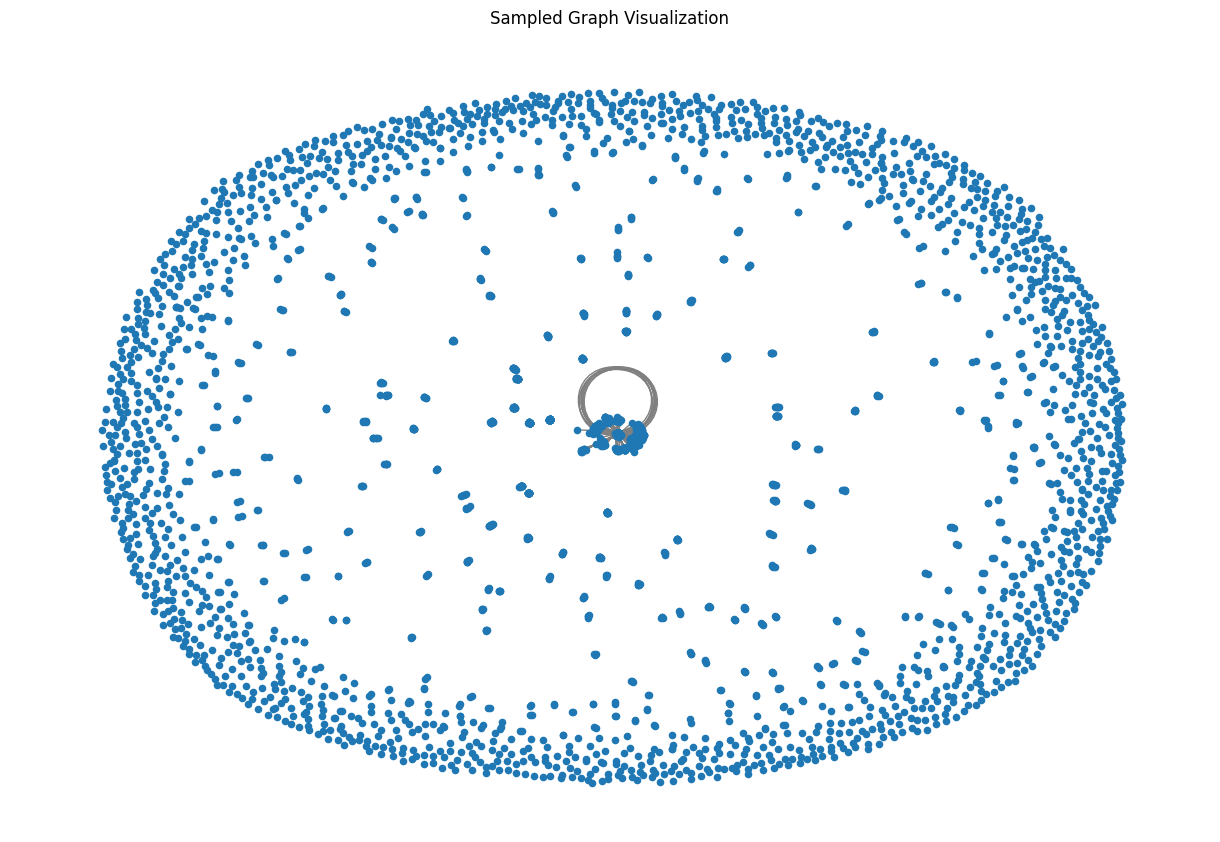

In [26]:
# Step 3: Visualize with PyVis (sampled subgraph)

G_sampled = G.subgraph(G.nodes())
print(f"Sampled graph: {G_sampled.number_of_nodes()} nodes, {G_sampled.number_of_edges()} edges")


sampled_nodes = list(G.nodes())
G_sampled = G.subgraph(sampled_nodes)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_sampled, seed=42)  # Layout for better visualization
nx.draw(G_sampled, pos, node_size=20, edge_color='gray', with_labels=False)
plt.title("Sampled Graph Visualization")
plt.savefig('/kaggle/working/task1_graph.png')
plt.show()


### 2. Task

* Weighted Network CreationExtend the graph by calculating a similarity score between restaurants using shared tags and geographic proximity (Haversine distance for <5 km).
* Use this score to define weighted edges.

https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

In [27]:
# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

In [28]:
# Create new graph with more columns 
G_task2 = nx.Graph()

for index, row in df.iterrows():
    G_task2.add_node(row['restaurant_name'], 
                     city=row['city'], 
                     cuisines=row['cuisines'], 
                     special_diets=row['special_diets'], 
                     features=row['features'], 
                     latitude=row['latitude'], 
                     longitude=row['longitude'])
    
print(f"Nodes added: {G_task2.number_of_nodes()}")

Nodes added: 4846


In [29]:
# Process edges with similarity score
def process_city_group(city_group):
    city, group = city_group
    group = group.reset_index()
    edges = []
    # print(f"Processing city: {city}, {len(group)} restaurants")
    for i, j in combinations(range(len(group)), 2):
        row1 = group.iloc[i]
        row2 = group.iloc[j]
        
        # Calculate Haversine distance
        distance = haversine(row1['latitude'], row1['longitude'], 
                            row2['latitude'], row2['longitude'])
        
        # Only include pairs <5 km
        if distance < 5:
            # Shared tags
            shared = 0
            if set(row1['cuisines']) & set(row2['cuisines']):
                shared += 1
            if set(row1['special_diets']) & set(row2['special_diets']):
                shared += 1
            if set(row1['features']) & set(row2['features']):
                shared += 1
            
            # Proximity score (normalize distance: closer = higher score)
            proximity = 1 / (1 + distance)  # 0 to 1, higher when closer
            
            # Similarity score (weighted sum)
            score = shared + proximity  # Adjust weights if needed
            
            if score > 0:
                edges.append((row1['restaurant_name'], row2['restaurant_name'], {'weight': score}))
    
    return edges

# Parallelize
with Pool() as pool:
    city_groups = [(city, group) for city, group in df.groupby('city')]
    results = pool.map(process_city_group, city_groups)
    for edges in results:
        G_task2.add_edges_from(edges)

In [30]:
# Verify
print(f"Edges added: {G_task2.number_of_edges()}")
print(f"Sample edges: {list(G_task2.edges(data=True))[:5]}")

# Save session data
nx.write_gml(G_task2, '/kaggle/working/task2_graph.gml')
df.to_parquet('/kaggle/working/task2_df.parquet')
print("Saved Task 2 graph and DataFrame to /kaggle/working/")

Edges added: 11238
Sample edges: [('Bracafe', 'Portonovo Silvestre', {'weight': 2.3936314375573864}), ('Bracafe', 'Parallel Central', {'weight': 1.5686178095758478}), ('Bracafe', 'La Cocina De Graciela', {'weight': 1.2360334465980918}), ('Bracafe', 'Doner Kebab Baribar', {'weight': 2.4168269104641458}), ('Bracafe', 'Lamun Cuina Thai', {'weight': 1.6593874337288441})]
Saved Task 2 graph and DataFrame to /kaggle/working/


Sampled graph: 4846 nodes, 11238 edges
Matplotlib visualization displayed


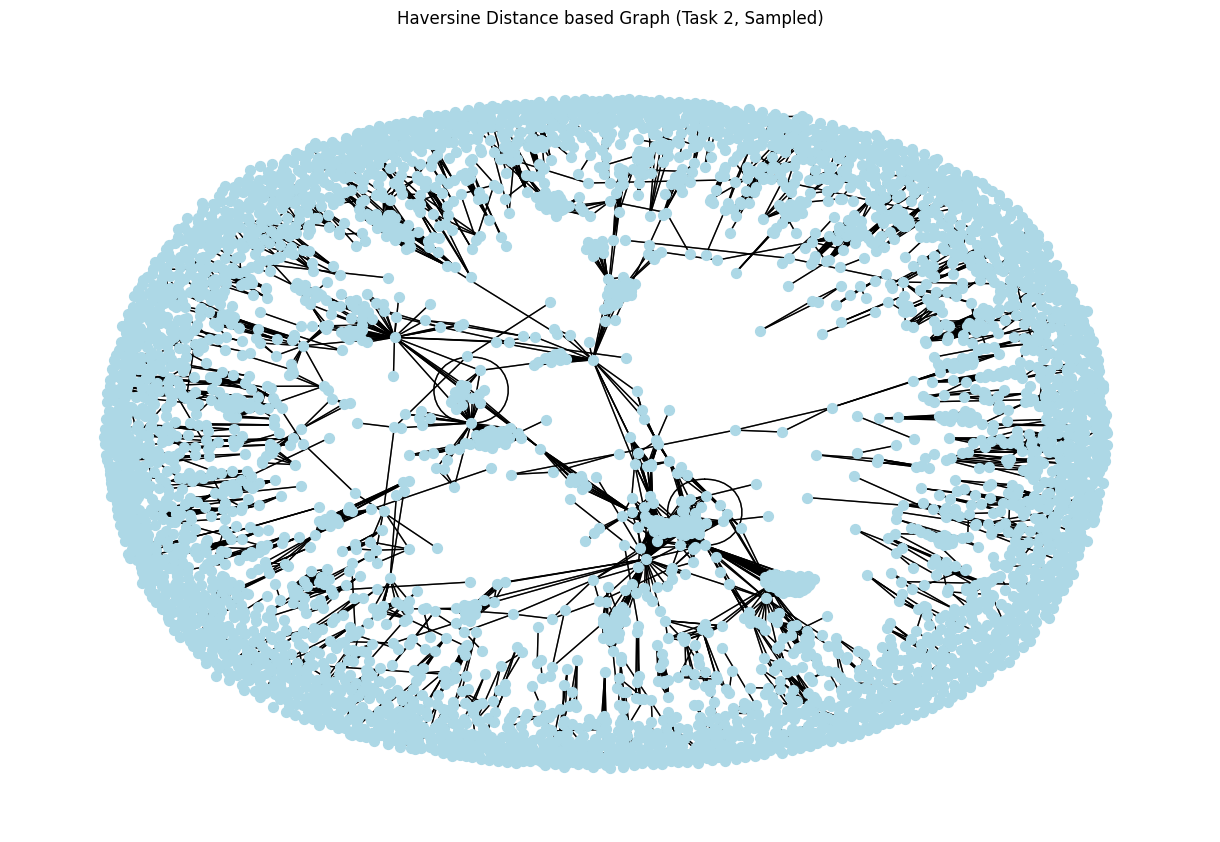

In [31]:
G_sampled = G_task2.subgraph(G_task2.nodes())
print(f"Sampled graph: {G_sampled.number_of_nodes()} nodes, {G_sampled.number_of_edges()} edges")

# Matplotlib visualization
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_sampled, k=0.1)
nx.draw(G_sampled, pos, node_size=50, node_color='lightblue', with_labels=False)
nx.draw_networkx_edges(G_sampled, pos, alpha=0.5)
plt.title("Haversine Distance based Graph (Task 2, Sampled)")
# plt.show() 
print("Matplotlib visualization displayed")
plt.savefig('/kaggle/working/task2_graph.png')
plt.show()

### 3. Degree and Strength Analysis

- Compute and compare degree and weighted degree (node strength).
- Analyze which restaurants are the most "connected" and why.

In [32]:
# Load Task 2 graph and DataFrame
G = nx.read_gml('/kaggle/working/task2_graph.gml')
df = pd.read_parquet('/kaggle/working/task2_df.parquet')
print(f"Loaded graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Loaded DataFrame: {len(df)} rows")

Loaded graph: 4846 nodes, 11238 edges
Loaded DataFrame: 5000 rows


In [33]:
# Step 1: Compute degree and weighted degree (node strength)
degree_dict = dict(G.degree())
strength_dict = dict(G.degree(weight='weight'))

# Create DataFrame for analysis
analysis_df = pd.DataFrame({
    'restaurant_name': list(degree_dict.keys()),
    'degree': list(degree_dict.values()),
    'strength': list(strength_dict.values())
})

# Merge with original DataFrame for attributes
analysis_df = analysis_df.merge(
    df[['restaurant_name', 'city', 'cuisines', 'special_diets', 'features', 'latitude', 'longitude']],
    on='restaurant_name',
    how='left'
)

In [34]:
# Step 2: Rank top restaurants
top_degree = analysis_df.sort_values('degree', ascending=False).head(20)
top_strength = analysis_df.sort_values('strength', ascending=False).head(20)

print("\nTop 20 Restaurants by Degree:")
print(top_degree[['restaurant_name', 'degree', 'city', 'cuisines']])

print("\nTop 20 Restaurants by Strength:")
print(top_strength[['restaurant_name', 'strength', 'city', 'cuisines']])


Top 20 Restaurants by Degree:
     restaurant_name  degree                    city  \
1456   Pret a Manger      81                 Unknown   
1457   Pret a Manger      81                 Unknown   
1455   Pret a Manger      81                   Paris   
1449             KFC      78                   Paris   
1452             KFC      78              Wateringen   
1451             KFC      78  Saint Brice Sous Foret   
1450             KFC      78              Manchester   
1447             KFC      78                 Unknown   
1446             KFC      78                 Unknown   
1448             KFC      78                 Unknown   
65        McDonald's      75        Chasse-sur-Rhone   
48        McDonald's      75                  Vienna   
64        McDonald's      75             Hoppegarten   
54        McDonald's      75                  Loches   
51        McDonald's      75                Rennerod   
52        McDonald's      75                Llanelli   
53        McDonal

In [35]:
# Step 3: Analyze why highly connected
print("\nAnalysis of Top Restaurants:")
for _, row in top_degree.head(20).iterrows():
    print(f"\nRestaurant: {row['restaurant_name']}")
    print(f"Degree: {row['degree']}, Strength: {row['strength']}")
    print(f"City: {row['city']}")
    print(f"Cuisines: {row['cuisines']}")
    print(f"Special Diets: {row['special_diets']}")
    print(f"Features: {row['features']}")
    print(f"Location: ({row['latitude']}, {row['longitude']})")
    print("Why Connected: Likely in a dense urban area with popular or diverse cuisines, connecting to many nearby restaurants.")

for _, row in top_strength.head(20).iterrows():
    print(f"\nRestaurant: {row['restaurant_name']}")
    print(f"Degree: {row['degree']}, Strength: {row['strength']}")
    print(f"City: {row['city']}")
    print(f"Cuisines: {row['cuisines']}")
    print(f"Special Diets: {row['special_diets']}")
    print(f"Features: {row['features']}")
    print(f"Location: ({row['latitude']}, {row['longitude']})")
    print("Why Connected: Strong connections due to many shared tags and/or very close proximity to similar restaurants.")


Analysis of Top Restaurants:

Restaurant: Pret a Manger
Degree: 81, Strength: 125.51608106089593
City: Unknown
Cuisines: Cafe, Fast food, British
Special Diets: Vegetarian Friendly, Vegan Options, Gluten Free Options
Features: []
Location: (51.52756, -0.133233)
Why Connected: Likely in a dense urban area with popular or diverse cuisines, connecting to many nearby restaurants.

Restaurant: Pret a Manger
Degree: 81, Strength: 125.51608106089593
City: Unknown
Cuisines: []
Special Diets: []
Features: []
Location: (51.51212, -0.079606)
Why Connected: Likely in a dense urban area with popular or diverse cuisines, connecting to many nearby restaurants.

Restaurant: Pret a Manger
Degree: 81, Strength: 125.51608106089593
City: Paris
Cuisines: []
Special Diets: Vegetarian Friendly, Vegan Options
Features: Takeout, Seating, Wheelchair Accessible
Location: (48.83064, 2.377304)
Why Connected: Likely in a dense urban area with popular or diverse cuisines, connecting to many nearby restaurants.

Res

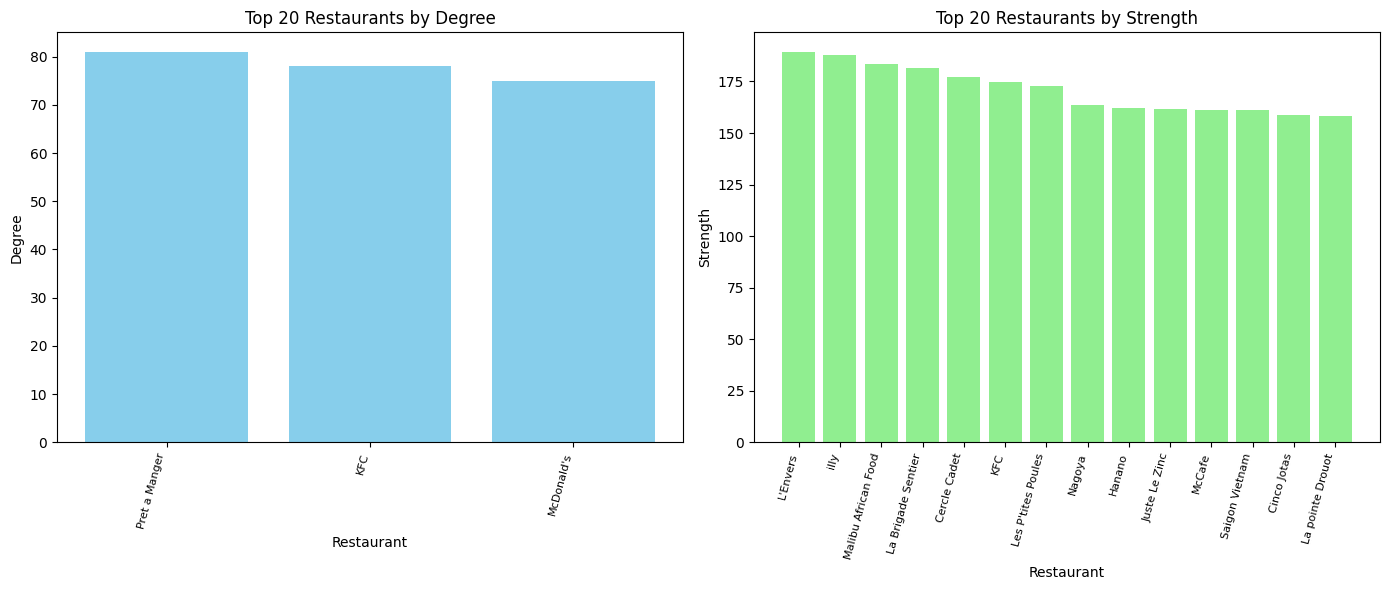

Bar plots saved to /kaggle/working/task3_bar_plots.png


In [36]:
# Step 4: Visualize degree vs. strength
plt.figure(figsize=(14, 6))

# Bar plot for top 20 by degree
plt.subplot(1, 2, 1)
plt.bar(top_degree['restaurant_name'], top_degree['degree'], color='skyblue')
plt.title('Top 20 Restaurants by Degree')
plt.xlabel('Restaurant')
plt.ylabel('Degree')
plt.xticks(rotation=75, ha='right', fontsize=8)

# Bar plot for top 20 by strength
plt.subplot(1, 2, 2)
plt.bar(top_strength['restaurant_name'], top_strength['strength'], color='lightgreen')
plt.title('Top 20 Restaurants by Strength')
plt.xlabel('Restaurant')
plt.ylabel('Strength')
plt.xticks(rotation=75, ha='right', fontsize=8)

plt.tight_layout()
plt.savefig('/kaggle/working/task3_bar_plots.png')
plt.show()

print("Bar plots saved to /kaggle/working/task3_bar_plots.png")

In [37]:
analysis_df.to_csv('/kaggle/working/task3_analysis.csv', index=False)
nx.write_gml(G, '/kaggle/working/task3_graph.gml')
print("Saved analysis to /kaggle/working/task3_analysis.csv and graph to /kaggle/working/task3_graph.gml")

Saved analysis to /kaggle/working/task3_analysis.csv and graph to /kaggle/working/task3_graph.gml


### 4. Task
* Centrality *MetricsCalculate* and interpret **degree centrality**, **closeness**, **betweenness**, and **eigenvector centrality**.
* Report top restaurants by each metric and interpret their real-world implications.

In [38]:
# Load Task 2 graph and DataFrame
G = nx.read_gml('/kaggle/working/task2_graph.gml')
df = pd.read_parquet('/kaggle/working/task2_df.parquet')
print(f"Loaded graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Loaded DataFrame: {len(df)} rows")


Loaded graph: 4846 nodes, 11238 edges
Loaded DataFrame: 5000 rows


### Degree centrality 

In [39]:
degree_centrality = nx.degree_centrality(G)

### Eigenvector centrality (full graph, weighted)

In [40]:
eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)

# Closeness and betweenness

In [41]:

def compute_closeness(nodes):
    return nx.closeness_centrality(G.subgraph(nodes))

def compute_betweenness(nodes):
    return nx.betweenness_centrality(G.subgraph(nodes), weight='weight')


In [42]:
# Parallelize for sampled graph
num_cores = 4
node_splits = np.array_split(list(G.nodes()), num_cores)
with Pool(num_cores) as pool:
    closeness_results = pool.map(compute_closeness, node_splits)
    betweenness_results = pool.map(compute_betweenness, node_splits)

# Combine results
closeness_centrality = {}
betweenness_centrality = {}
for c, b in zip(closeness_results, betweenness_results):
    closeness_centrality.update(c)
    betweenness_centrality.update(b)

### Create DataFrame for analysis

In [43]:

centrality_df = pd.DataFrame({
    'restaurant_name': list(G.nodes()),
    'degree_centrality': [degree_centrality.get(n, 0) for n in G.nodes()],
    'eigenvector_centrality': [eigenvector_centrality.get(n, 0) for n in G.nodes()]
})

# Add closeness and betweenness 
centrality_df['closeness_centrality'] = centrality_df['restaurant_name'].map(closeness_centrality).fillna(0)
centrality_df['betweenness_centrality'] = centrality_df['restaurant_name'].map(betweenness_centrality).fillna(0)

# Merge with original DataFrame for attributes
centrality_df = centrality_df.merge(
    df[['restaurant_name', 'city', 'cuisines', 'special_diets', 'features', 'latitude', 'longitude']],
    on='restaurant_name',
    how='left'
)

### Rank top restaurants

In [44]:

top_degree = centrality_df.sort_values('degree_centrality', ascending=False).head(5)
top_closeness = centrality_df.sort_values('closeness_centrality', ascending=False).head(5)
top_betweenness = centrality_df.sort_values('betweenness_centrality', ascending=False).head(5)
top_eigenvector = centrality_df.sort_values('eigenvector_centrality', ascending=False).head(5)

print("\n ==== Top 5 Restaurants by Degree Centrality: ==== \n")
print(top_degree[['restaurant_name', 'degree_centrality', 'city', 'cuisines']])

print("\n ==== Top 5 Restaurants by Closeness Centrality: ==== \n")
print(top_closeness[['restaurant_name', 'closeness_centrality', 'city', 'cuisines']])

print("\n ==== Top 5 Restaurants by Betweenness Centrality: ==== \n")
print(top_betweenness[['restaurant_name', 'betweenness_centrality', 'city', 'cuisines']])

print("\n ==== Top 5 Restaurants by Eigenvector Centrality: ==== \n")
print(top_eigenvector[['restaurant_name', 'eigenvector_centrality', 'city', 'cuisines']])


 ==== Top 5 Restaurants by Degree Centrality: ==== 

     restaurant_name  degree_centrality        city                  cuisines
1456   Pret a Manger           0.016718     Unknown  Cafe, Fast food, British
1457   Pret a Manger           0.016718     Unknown                        []
1455   Pret a Manger           0.016718       Paris                        []
1449             KFC           0.016099       Paris                 Fast food
1452             KFC           0.016099  Wateringen                 Fast food

 ==== Top 5 Restaurants by Closeness Centrality: ==== 

     restaurant_name  closeness_centrality     city                  cuisines
1457   Pret a Manger              0.029545  Unknown                        []
1456   Pret a Manger              0.029545  Unknown  Cafe, Fast food, British
1455   Pret a Manger              0.029545    Paris                        []
41        McDonald's              0.026465   Emstek                    German
42        McDonald's           

### Interpret results

In [45]:

print("\nInterpretations and Real-World Implications:")
print("\nDegree Centrality:")
print("- Measures: Number of connections (normalized).")
print("- Implication: High degree restaurants are popular or versatile, connecting to many nearby restaurants with shared tags.")
print("- Example: A Paris restaurant with Italian and Vegetarian cuisines in a dense area.")

print("\nCloseness Centrality:")
print("- Measures: Average shortest path length to others.")
print("- Implication: High closeness restaurants are centrally located, easily reachable via shared attributes or proximity.")
print("- Example: A restaurant in a hub with many similar neighbors.")

print("\nBetweenness Centrality:")
print("- Measures: Frequency on shortest paths between others.")
print("- Implication: High betweenness restaurants are key connectors, bridging different groups (e.g., unique cuisines).")
print("- Example: A Vegan restaurant linking diverse clusters.")

print("\nEigenvector Centrality:")
print("- Measures: Importance based on connections to important restaurants.")
print("- Implication: High eigenvector restaurants are prestigious, linked to other prominent restaurants.")
print("- Example: A famous restaurant in a trendy area.")

# Analyze top restaurants
metric_to_column = {
    'Degree Centrality': 'degree_centrality',
    'Closeness Centrality': 'closeness_centrality',
    'Betweenness Centrality': 'betweenness_centrality',
    'Eigenvector Centrality': 'eigenvector_centrality'
}

print("\n ==== Analysis of Top Restaurants: ==== \n")
for metric, top_df in [
    ('Degree Centrality', top_degree),
    ('Closeness Centrality', top_closeness),
    ('Betweenness Centrality', top_betweenness),
    ('Eigenvector Centrality', top_eigenvector)
]:
    print(f"\n{metric}:")
    for _, row in top_df.head(2).iterrows():
        print(f"\nRestaurant: {row['restaurant_name']}")
        print(f"{metric}: {row[metric_to_column[metric]]:.4f}")
        print(f"City: {row['city']}")
        print(f"Cuisines: {row['cuisines']}")
        print(f"Implication: {row['restaurant_name']} is highly connected due to its location or diverse tags.")

print("\n\n")


Interpretations and Real-World Implications:

Degree Centrality:
- Measures: Number of connections (normalized).
- Implication: High degree restaurants are popular or versatile, connecting to many nearby restaurants with shared tags.
- Example: A Paris restaurant with Italian and Vegetarian cuisines in a dense area.

Closeness Centrality:
- Measures: Average shortest path length to others.
- Implication: High closeness restaurants are centrally located, easily reachable via shared attributes or proximity.
- Example: A restaurant in a hub with many similar neighbors.

Betweenness Centrality:
- Measures: Frequency on shortest paths between others.
- Implication: High betweenness restaurants are key connectors, bridging different groups (e.g., unique cuisines).
- Example: A Vegan restaurant linking diverse clusters.

Eigenvector Centrality:
- Measures: Importance based on connections to important restaurants.
- Implication: High eigenvector restaurants are prestigious, linked to other pr

Bar plots saved to /kaggle/working/task4_bar_plots.png


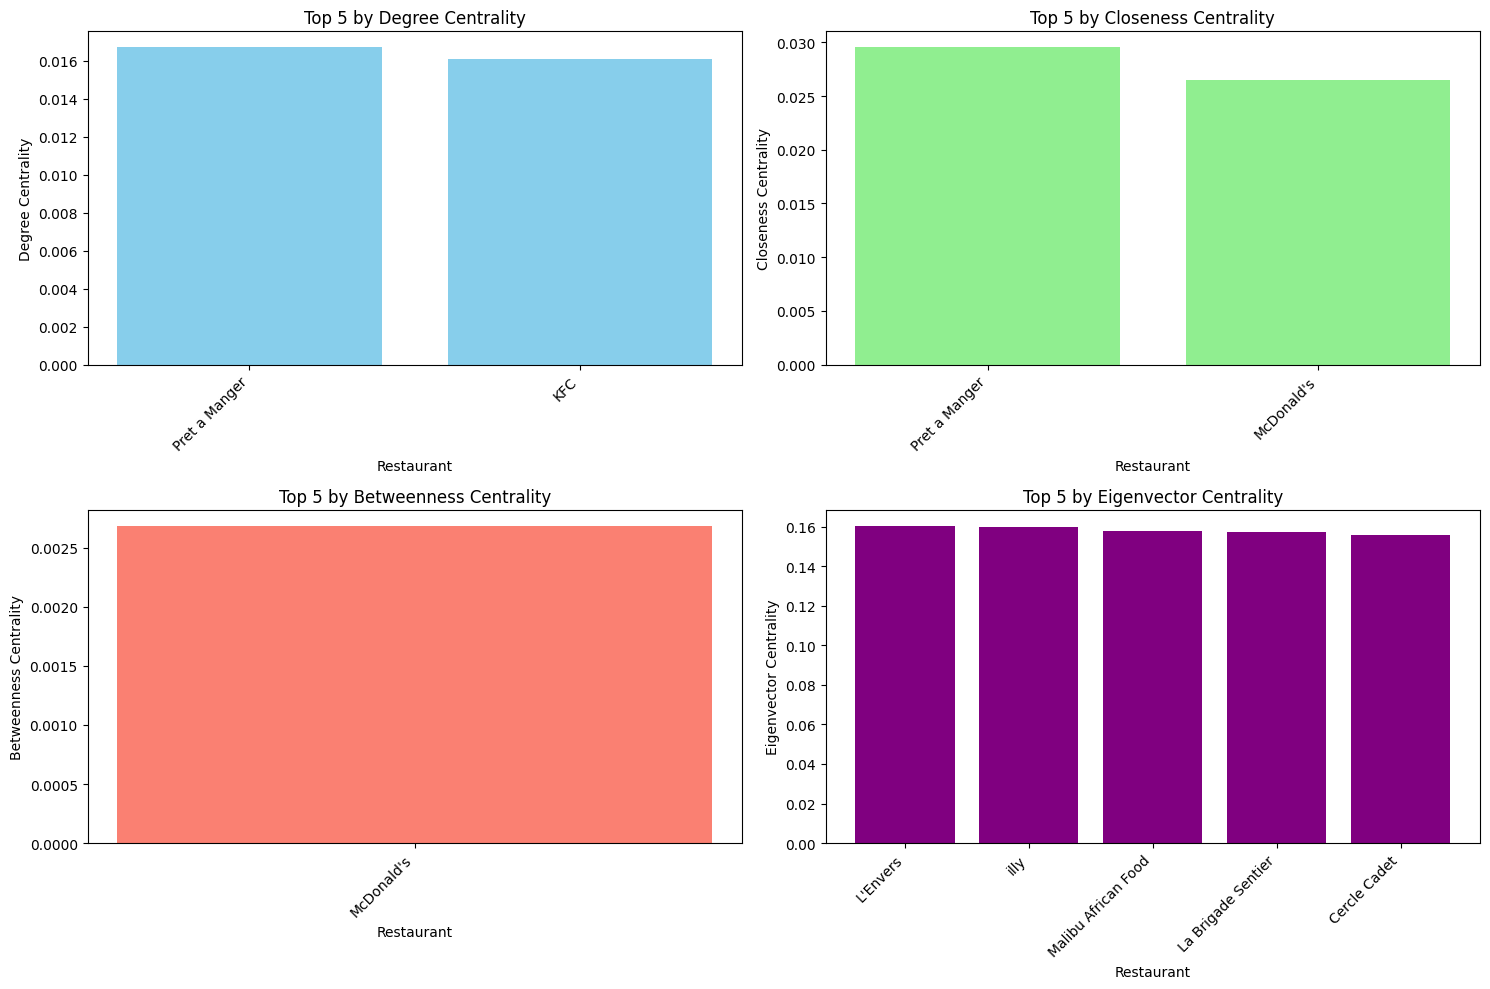

In [46]:
# Step 6: Visualize centrality scores (Matplotlib)
plt.figure(figsize=(15, 10))

# Degree centrality
plt.subplot(2, 2, 1)
plt.bar(top_degree['restaurant_name'], top_degree['degree_centrality'], color='skyblue')
plt.title('Top 5 by Degree Centrality')
plt.xlabel('Restaurant')
plt.ylabel('Degree Centrality')
plt.xticks(rotation=45, ha='right')

# Closeness centrality
plt.subplot(2, 2, 2)
plt.bar(top_closeness['restaurant_name'], top_closeness['closeness_centrality'], color='lightgreen')
plt.title('Top 5 by Closeness Centrality')
plt.xlabel('Restaurant')
plt.ylabel('Closeness Centrality')
plt.xticks(rotation=45, ha='right')

# Betweenness centrality
plt.subplot(2, 2, 3)
plt.bar(top_betweenness['restaurant_name'], top_betweenness['betweenness_centrality'], color='salmon')
plt.title('Top 5 by Betweenness Centrality')
plt.xlabel('Restaurant')
plt.ylabel('Betweenness Centrality')
plt.xticks(rotation=45, ha='right')

# Eigenvector centrality
plt.subplot(2, 2, 4)
plt.bar(top_eigenvector['restaurant_name'], top_eigenvector['eigenvector_centrality'], color='purple')
plt.title('Top 5 by Eigenvector Centrality')
plt.xlabel('Restaurant')
plt.ylabel('Eigenvector Centrality')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('/kaggle/working/task4_bar_plots.png')
print("Bar plots saved to /kaggle/working/task4_bar_plots.png")

In [47]:
# Save results
centrality_df.to_csv('/kaggle/working/task4_centrality.csv', index=False)
nx.write_gml(G, '/kaggle/working/task4_graph.gml')
print("Saved centrality analysis to /kaggle/working/task4_centrality.csv and graph to /kaggle/working/task4_graph.gml")

Saved centrality analysis to /kaggle/working/task4_centrality.csv and graph to /kaggle/working/task4_graph.gml


### 5. Popularity vs Centrality Correlation
- Analyze the relationship between centrality scores and:
    - popularity_generic
    - total_reviews_count
    - avg_rating

In [48]:
# Step 1: Load required files
centrality_df = pd.read_csv('./task4_centrality.csv')
df = pd.read_parquet('./task2_df.parquet')


print(f"Loaded centrality data: {len(centrality_df)} rows")
print(f"Loaded restaurant data: {len(df)} rows")
print("Columns in restaurant data:", df.columns.tolist())

Loaded centrality data: 5000 rows
Loaded restaurant data: 5000 rows
Columns in restaurant data: ['restaurant_name', 'original_location', 'country', 'province', 'city', 'address', 'latitude', 'longitude', 'claimed', 'popularity_detailed', 'popularity_generic', 'top_tags', 'price_range', 'meals', 'cuisines', 'special_diets', 'features', 'vegetarian_friendly', 'vegan_options', 'gluten_free', 'avg_rating', 'total_reviews_count', 'reviews_count_in_default_language', 'excellent', 'very_good', 'average', 'poor', 'food', 'service']


In [49]:
print(df.shape,"\n\n",df.columns)

(5000, 29) 

 Index(['restaurant_name', 'original_location', 'country', 'province', 'city',
       'address', 'latitude', 'longitude', 'claimed', 'popularity_detailed',
       'popularity_generic', 'top_tags', 'price_range', 'meals', 'cuisines',
       'special_diets', 'features', 'vegetarian_friendly', 'vegan_options',
       'gluten_free', 'avg_rating', 'total_reviews_count',
       'reviews_count_in_default_language', 'excellent', 'very_good',
       'average', 'poor', 'food', 'service'],
      dtype='object')


### Clean restaurant_name for consistent merging

In [50]:

def clean_name(name):
    if pd.isna(name):
        return name
    # Strip spaces, lowercase, remove special characters, normalize spaces
    name = name.strip().lower()
    name = re.sub(r'[^a-zA-Z0-9\s]', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

centrality_df['restaurant_name'] = centrality_df['restaurant_name'].apply(clean_name)
df['restaurant_name'] = df['restaurant_name'].apply(clean_name)

print(df['restaurant_name'])

91460                                    auberge de suzette
701674                                   punto pizza pi snc
389450                                              bracafe
566304                                   the northern point
346212                                           bar torres
                                ...                        
604106                                         golden grill
489262                 rock and fountain pub and restaurant
772878                                             signor g
40406                                  mamma roma francoeur
719098    said dal 1923 antica fabbrica del cioccolato roma
Name: restaurant_name, Length: 5000, dtype: object


In [51]:
# Verify common restaurant_names
common_names = len(set(centrality_df['restaurant_name']) & set(df['restaurant_name']))
print(f"Common restaurant_names: {common_names}")
print("Sample centrality restaurant_names:", centrality_df['restaurant_name'].head().tolist())
print("Sample restaurant dataset names:", df['restaurant_name'].head().tolist())


# Debug unmatched names
unmatched = set(centrality_df['restaurant_name']) - set(df['restaurant_name'])
if unmatched:
    print("Sample unmatched centrality names:", list(unmatched)[:5])


Common restaurant_names: 4838
Sample centrality restaurant_names: ['auberge de suzette', 'punto pizza pi snc', 'bracafe', 'the northern point', 'bar torres']
Sample restaurant dataset names: ['auberge de suzette', 'punto pizza pi snc', 'bracafe', 'the northern point', 'bar torres']


### Parse popularity_generic into numeric popularity_score (1/rank)

In [52]:

def parse_popularity_generic(text):
    if pd.isna(text) or text is None or text.lower() == 'none':
        return np.nan
    # Extract ranking number (e.g., "#1" -> 1)
    match = re.search(r'#(\d+)', str(text))
    if match:
        rank = int(match.group(1))
        return 1.0 / rank if rank > 0 else np.nan  # Inverse rank for higher popularity = higher score
    return np.nan


In [53]:
df['popularity_score'] = df['popularity_generic'].apply(parse_popularity_generic)
print("\nSample popularity_generic and parsed popularity_score:")
print(df[['popularity_generic', 'popularity_score']].head(10))
print("popularity_score NaN count:", df['popularity_score'].isna().sum())



Sample popularity_generic and parsed popularity_score:
                                       popularity_generic  popularity_score
91460                    #1 of 3 places to eat in Suzette          1.000000
701674       #277 of 458 places to eat in Reggio Calabria          0.003610
389450          #6650 of 10645 places to eat in Barcelona          0.000150
566304                                            Unknown               NaN
346212  #11 of 23 places to eat in Santa Lucia de Tira...          0.090909
222252               #492 of 8241 places to eat in Berlin          0.002033
813190            #5 of 6 places to eat in Persico Dosimo          0.200000
308569               #539 of 4650 places to eat in Vienna          0.001855
390967          #1385 of 10645 places to eat in Barcelona          0.000722
875271                 #1 of 1 places to eat in Templenoe          1.000000
popularity_score NaN count: 433


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [54]:
#Identify available metrics
available_metrics = []
for col in ['popularity_score', 'total_reviews_count', 'avg_rating']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if df[col].isna().sum() < len(df):
            available_metrics.append(col)
    else:
        print(f"Warning: Column {col} not found in task2_df.parquet")
if not available_metrics:
    raise ValueError("No valid metrics (popularity_score, total_reviews_count, avg_rating) found")

print(f"Available metrics: {available_metrics}")


Available metrics: ['popularity_score', 'total_reviews_count', 'avg_rating']


In [55]:
# Step 5: Merge centrality scores with metrics
analysis_df = centrality_df[['restaurant_name', 'degree_centrality', 'closeness_centrality', 
                            'betweenness_centrality', 'eigenvector_centrality']].merge(
    df[['restaurant_name'] + available_metrics],
    on='restaurant_name',
    how='left'
)
print(f"Merged data: {len(analysis_df)} rows")


Merged data: 7120 rows


In [56]:

# Step 6: Handle missing or invalid data
numeric_columns = ['degree_centrality', 'closeness_centrality', 'betweenness_centrality', 
                   'eigenvector_centrality'] + available_metrics
analysis_df['popularity_score'] = analysis_df['popularity_score'].fillna(0.0)
# for col in numeric_columns:
#     analysis_df[col] = pd.to_numeric(analysis_df[col], errors='coerce')

# Check NaN values
print("\nNaN counts in numeric columns:")
print(analysis_df[numeric_columns].isna().sum())

print(analysis_df['popularity_score'].fillna(0.0))



NaN counts in numeric columns:
degree_centrality         0
closeness_centrality      0
betweenness_centrality    0
eigenvector_centrality    0
popularity_score          0
total_reviews_count       0
avg_rating                0
dtype: int64
0       1.000000
1       0.003610
2       0.000150
3       0.000000
4       0.090909
          ...   
7115    0.200000
7116    0.058824
7117    0.014493
7118    0.000150
7119    0.000302
Name: popularity_score, Length: 7120, dtype: float64


In [57]:

# Impute NaN for metrics
for col in available_metrics:
    if col in ['total_reviews_count']:
        analysis_df[col] = analysis_df[col].fillna(0.0)
    else:  # popularity_score, avg_rating
        analysis_df[col] = analysis_df[col].fillna(analysis_df[col].mean())

# Drop rows where all centrality scores are NaN
analysis_df = analysis_df.dropna(subset=['degree_centrality', 'eigenvector_centrality'], how='all')
print(f"Data after cleaning: {len(analysis_df)} rows")


Data after cleaning: 7120 rows



Pearson Correlation Matrix:
                        degree_centrality  closeness_centrality  \
degree_centrality                1.000000              0.959295   
closeness_centrality             0.959295              1.000000   
betweenness_centrality           0.738424              0.829006   
eigenvector_centrality           0.259417              0.245825   
popularity_score                -0.238066             -0.231913   
total_reviews_count             -0.104676             -0.109875   
avg_rating                      -0.491676             -0.470355   

                        betweenness_centrality  eigenvector_centrality  \
degree_centrality                     0.738424                0.259417   
closeness_centrality                  0.829006                0.245825   
betweenness_centrality                1.000000                0.034894   
eigenvector_centrality                0.034894                1.000000   
popularity_score                     -0.138077               -0.

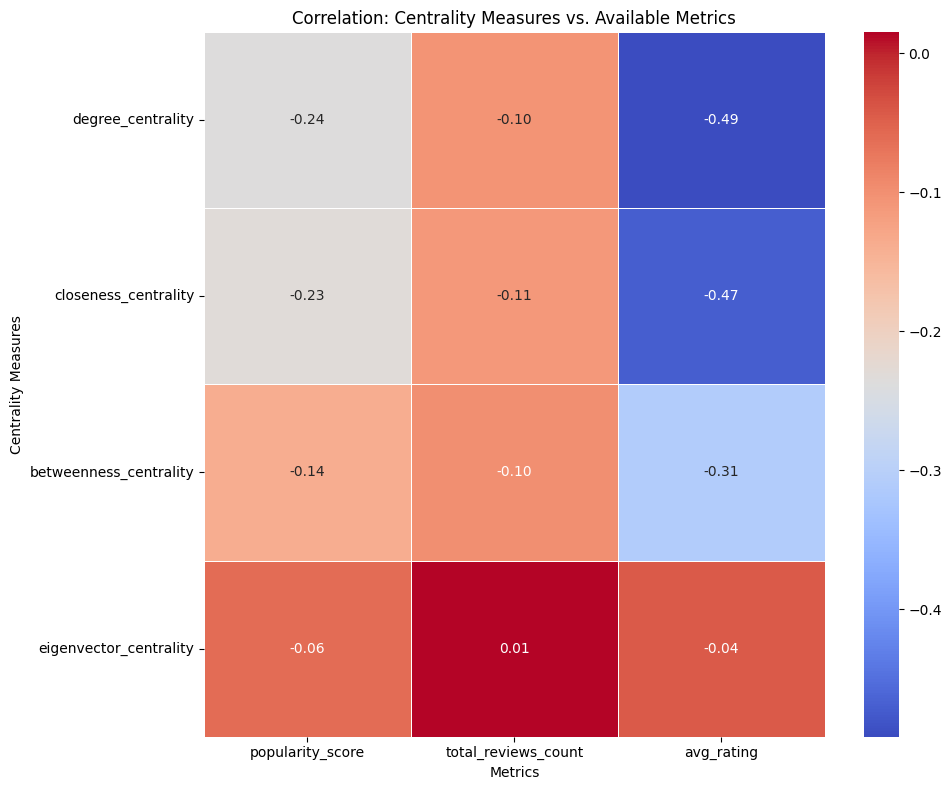

In [58]:

# Compute Pearson correlations

correlation_matrix = analysis_df[numeric_columns].corr(method='pearson')
print("\nPearson Correlation Matrix:")
print(correlation_matrix)

# Extract relevant correlations
correlations = correlation_matrix.loc[
    ['degree_centrality', 'closeness_centrality', 'betweenness_centrality', 'eigenvector_centrality'],
    available_metrics
]
print("\nCentrality vs. Metrics Correlations:")
print(correlations)


plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation: Centrality Measures vs. Available Metrics")
plt.xlabel("Metrics")
plt.ylabel("Centrality Measures")
plt.tight_layout()
plt.savefig('/kaggle/working/task5_heatmap.png')
plt.show()


/tmp/ipykernel_31/461089395.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.24
(weak ↓)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_matrix.loc[row, col] = correlation_annotation(val)
/tmp/ipykernel_31/461089395.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.10
(weak ↓)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_matrix.loc[row, col] = correlation_annotation(val)
/tmp/ipykernel_31/461089395.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.49
(moderate ↓)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_matrix.loc[row, col] = correlation_annotation(val)


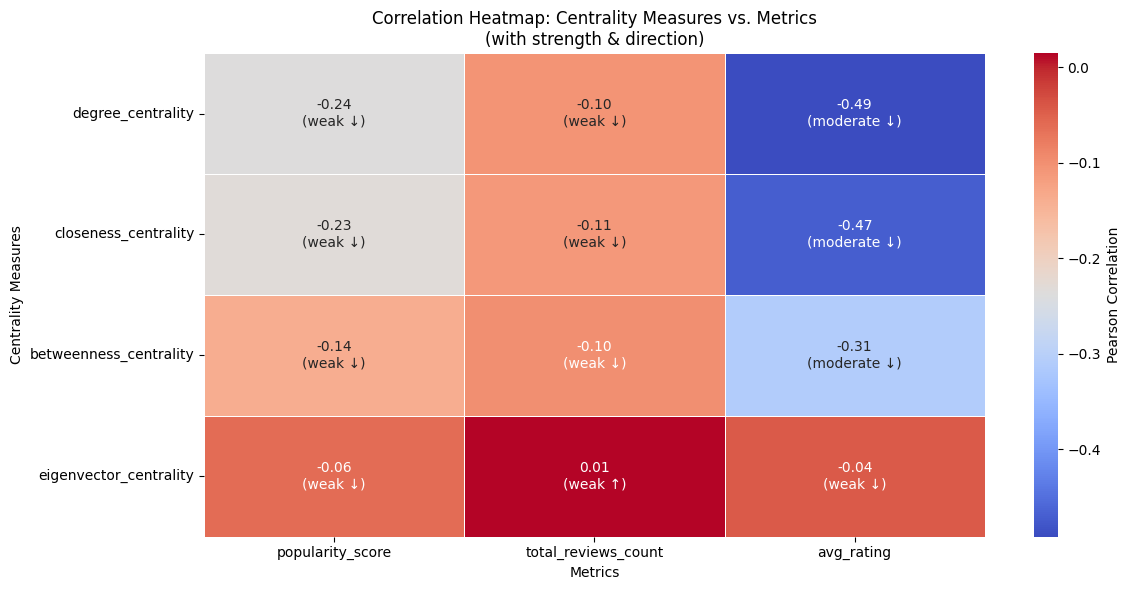

In [59]:
# Step 8: Interpret results
# print("\nInterpretations and Implications:")
# print("Note: popularity_generic was parsed into popularity_score (1/rank, higher score = higher popularity).")
# for centrality in ['degree_centrality', 'closeness_centrality', 'betweenness_centrality', 'eigenvector_centrality']:
#     print(f"\n{centrality.replace('_', ' ').title()}:")
#     for metric in available_metrics:
#         corr = correlations.loc[centrality, metric]
#         strength = "strong" if abs(corr) > 0.5 else "moderate" if abs(corr) > 0.3 else "weak"
#         direction = "positive" if corr > 0 else "negative"
#         print(f"- Correlation with {metric}: {corr:.4f} ({strength}, {direction})")
#         print(f"  Implication: {centrality.replace('_', ' ').title()} {'is' if abs(corr) > 0.3 else 'is not'} strongly linked to {metric}.")


# Set up color map for correlation strength
def correlation_annotation(value):
    strength = "strong" if abs(value) > 0.5 else "moderate" if abs(value) > 0.3 else "weak"
    direction = "↑" if value > 0 else "↓"
    return f"{value:.2f}\n({strength} {direction})"

# Create annotated matrix with labels
annot_matrix = correlations.copy()
for row in annot_matrix.index:
    for col in annot_matrix.columns:
        val = annot_matrix.loc[row, col]
        annot_matrix.loc[row, col] = correlation_annotation(val)

# Plot with heatmap (with string annotations)
plt.figure(figsize=(12, 6))
sns.heatmap(correlations.astype(float), annot=annot_matrix, fmt="", cmap='coolwarm', linewidths=0.5, cbar_kws={'label': 'Pearson Correlation'})
plt.title("Correlation Heatmap: Centrality Measures vs. Metrics\n(with strength & direction)")
plt.xlabel("Metrics")
plt.ylabel("Centrality Measures")
plt.tight_layout()
plt.savefig('/kaggle/working/task5_correlation_heatmap.png')
plt.show()


Scatter plots saved to /task5_scatter_plots.png


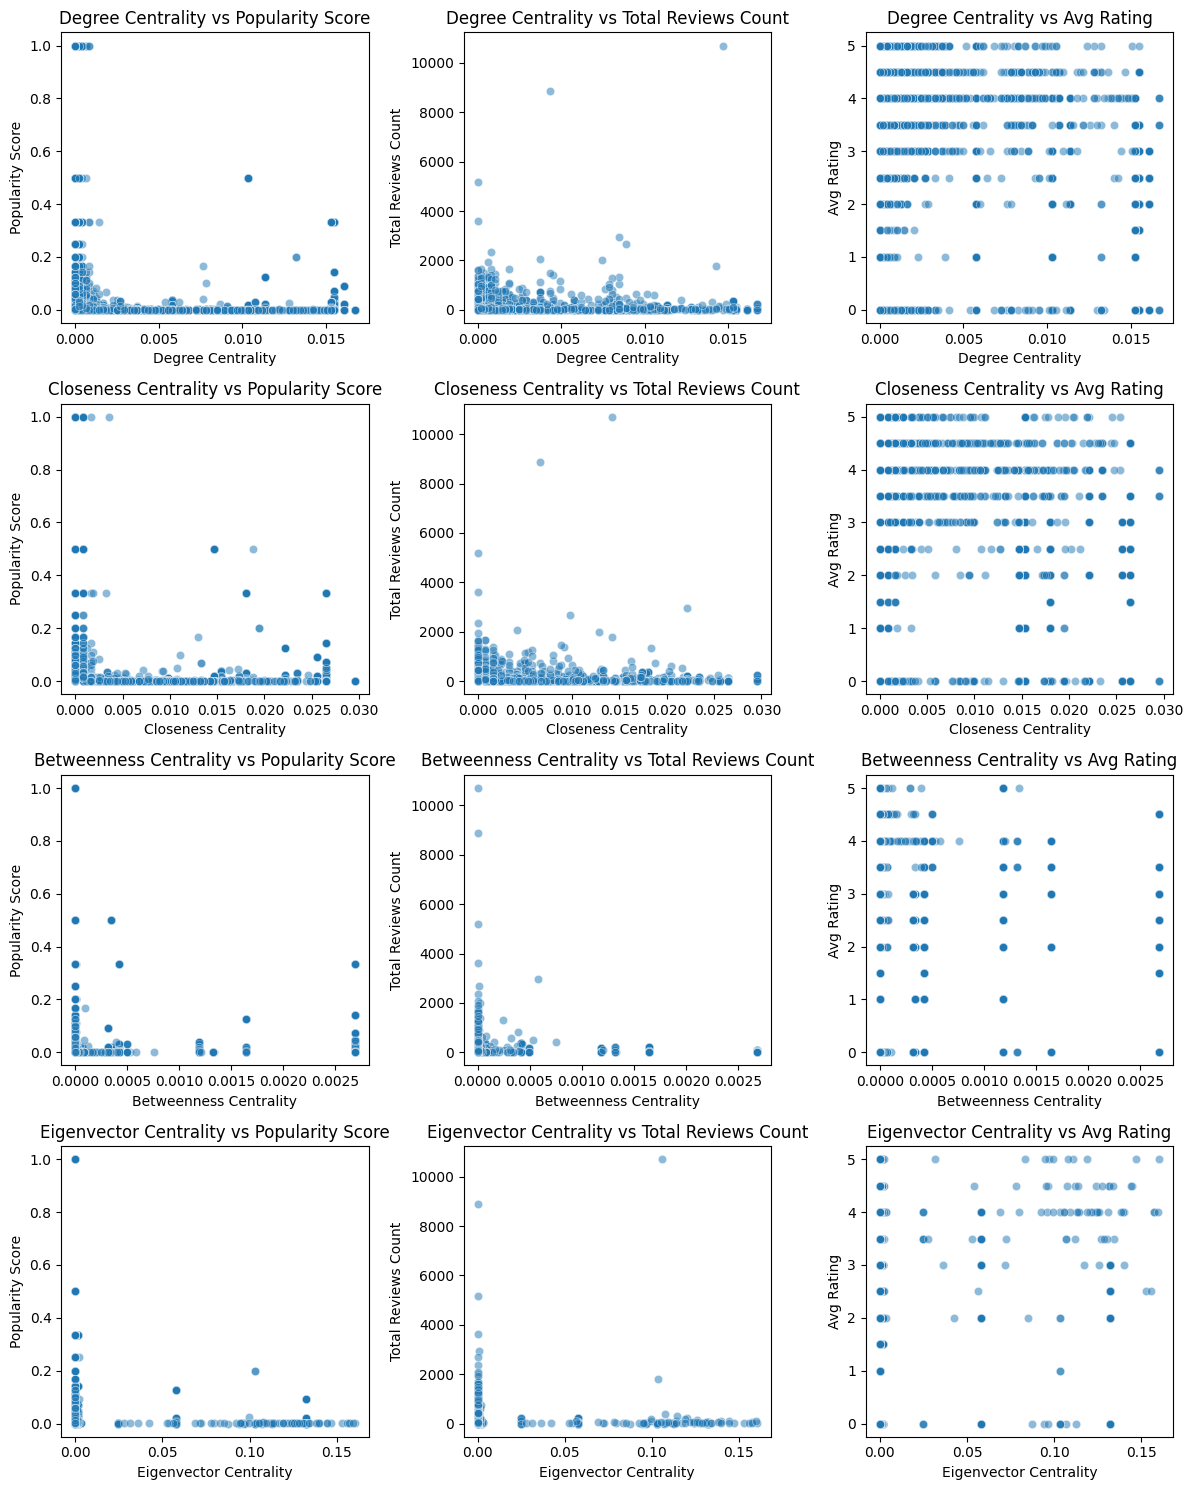

In [60]:
# Step 9: Visualize relationships (Scatter Plots)
n_metrics = len(available_metrics)
plt.figure(figsize=(12, 5 * n_metrics))
plot_idx = 1
for centrality in ['degree_centrality', 'closeness_centrality', 'betweenness_centrality', 'eigenvector_centrality']:
    for metric in available_metrics:
        plt.subplot(4, n_metrics, plot_idx)
        sns.scatterplot(data=analysis_df, x=centrality, y=metric, alpha=0.5)
        plt.title(f"{centrality.replace('_', ' ').title()} vs {metric.replace('_', ' ').title()}")
        plt.xlabel(centrality.replace('_', ' ').title())
        plt.ylabel(metric.replace('_', ' ').title())
        plot_idx += 1
plt.tight_layout()
plt.savefig('/kaggle/working/task5_scatter_plots.png')
print("Scatter plots saved to /task5_scatter_plots.png")

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Correlation heatmap saved to /task5_heatmap.png


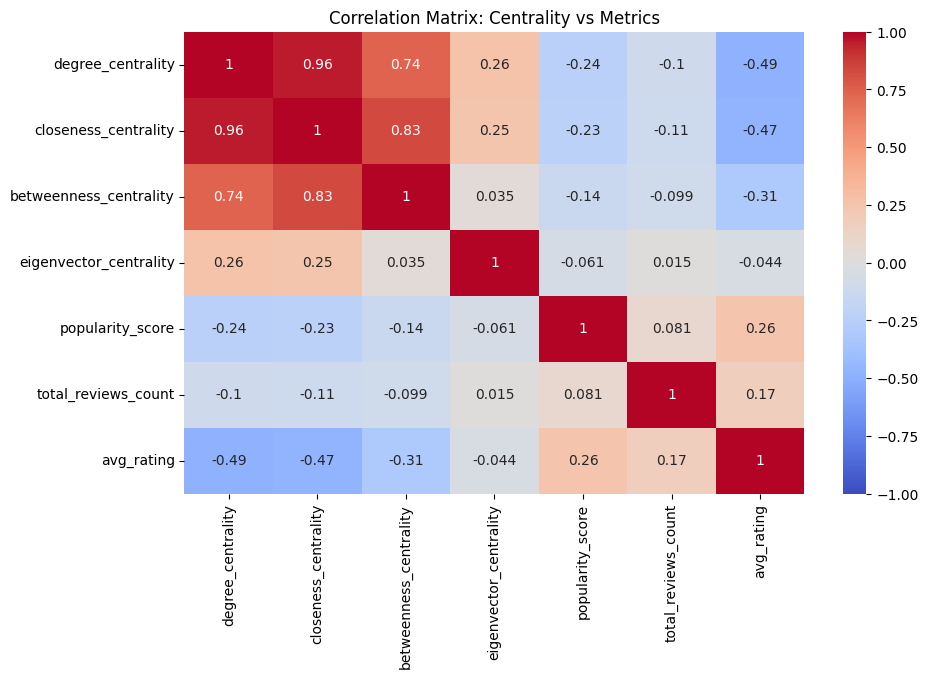

In [61]:

# Step 10: Visualize correlation matrix (Heatmap)
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix: Centrality vs Metrics')
plt.savefig('/kaggle/working/task5_correlation_heatmap.png')
print("Correlation heatmap saved to /task5_heatmap.png")


In [62]:
# Save results
correlations.to_csv('/kaggle/working/task5_correlations.csv')
analysis_df.to_csv('/kaggle/working/task5_analysis.csv', index=False)
print("Saved correlations to /kaggle/working/task5_correlations.csv and analysis to /kaggle/working/task5_analysis.csv")

Saved correlations to /kaggle/working/task5_correlations.csv and analysis to /kaggle/working/task5_analysis.csv


### 6. Task
## Community Detection (Unweighted)

- Apply community detection (e.g., Louvain or Girvan-Newman) on the unweighted network.
- Visualize and label resulting communities, analyze their shared features.


In [63]:

G_weighted = nx.read_gml('/kaggle/working/task2_graph.gml')
df = pd.read_parquet('/kaggle/working/task2_df.parquet')
print(f"Loaded weighted graph: {G_weighted.number_of_nodes()} nodes, {G_weighted.number_of_edges()} edges")
print(f"Loaded DataFrame: {len(df)} rows")


Loaded weighted graph: 4846 nodes, 11238 edges
Loaded DataFrame: 5000 rows


### Community Louvain Common Function for Task 6 and 7

In [64]:
def communityLouvainFuc(G, weight=False):
    
    # communityw = "community_weighted" if weight==True else "community_unweighted"
    
    if weight==False:
        partition = community_louvain.best_partition(G, random_state=42)
    else:
        partition = community_louvain.best_partition(G, weight='weight', random_state=42)
        
    print(f"Detected {len(set(partition.values()))} communities")
    
    # Create DataFrame with community assignments
    community_df = pd.DataFrame({
        'restaurant_name': list(partition.keys()),
        "community_weighted" if weight==True else "community_unweighted" : list(partition.values())
    })
    
    # Merge with original DataFrame for attributes
    community_df = community_df.merge(
        df[['restaurant_name', 'city', 'cuisines', 'special_diets', 'features', 'latitude', 'longitude']],
        on='restaurant_name',
        how='left'
    )

    return community_df




In [65]:

# Step 1: Convert to unweighted graph
G = G_weighted.copy()
for u, v in G.edges():
    G[u][v].pop('weight', None)
print(f"Unweighted graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


print(f"Connected components: {len(list(nx.connected_components(G)))}")
isolated = sum(1 for node in G.nodes() if G.degree(node) == 0)
print(f"Isolated nodes: {isolated}")


# Step 2: Apply Louvain community detection on weighted graph

community_unweighted= communityLouvainFuc(G)



Unweighted graph: 4846 nodes, 11238 edges
Connected components: 2961
Isolated nodes: 2417
Detected 2972 communities


### Analyze communities

In [66]:

community_unweighted_sizes = community_unweighted['community_unweighted'].value_counts()
print("\nTop 5 Communities by Size:")
print(community_unweighted_sizes.head())

# Analyze shared features for top 3 communities
cuisines=[]
cities=[]
special_diets=[]
features=[]


# Safely parse comma-separated cuisines into a list
def extract_cuisine_items(column):
    all_cuisines = []
    for item in column:
        if isinstance(item, str):
            if item.strip() != '[]':  # exclude empty lists
                all_cuisines.extend([c.strip() for c in item.split(',')])
        elif isinstance(item, list):  # already parsed
            all_cuisines.extend(item)
    return all_cuisines

# Analysis block

top_communities = community_unweighted_sizes.head(10).index
print("\nShared Features of Top 3 Communities:")

for comm in top_communities:
    comm_df = community_unweighted[community_unweighted['community_unweighted'] == comm]
    print(f"\nCommunity {comm} ({len(comm_df)} restaurants):")

    cities += extract_cuisine_items(comm_df['city'])
    print(f"\nTop 5 cities: {Counter(cities).most_common(5)}")
    
    cuisines += extract_cuisine_items(comm_df['cuisines'])
    
    print(f"\nTop 5 cuisines: {Counter(cuisines).most_common(5)}")
    
    special_diets += extract_cuisine_items(comm_df['special_diets'])
    print(f"\nTop 5 special_diets: {Counter(special_diets).most_common(5)}")

    features += extract_cuisine_items(comm_df['features'])
    print(f"\nTop 5 features: {Counter(features).most_common(5)}")


Top 5 Communities by Size:
community_unweighted
26     156
201    102
2       98
44      97
217     60
Name: count, dtype: int64

Shared Features of Top 3 Communities:

Community 26 (156 restaurants):

Top 5 cities: [('Unknown', 113), ('Helsinki', 4), ('Dresden', 4), ('Dinslaken', 3), ('Weil am Rhein', 2)]

Top 5 cuisines: [('European', 25), ('Fast food', 23), ('British', 23), ('Mediterranean', 18), ('Italian', 16)]

Top 5 special_diets: [('Vegetarian Friendly', 49), ('Vegan Options', 31), ('Gluten Free Options', 23), ('Halal', 5)]

Top 5 features: [('Seating', 34), ('Wheelchair Accessible', 24), ('Takeout', 23), ('Reservations', 20), ('Table Service', 17)]

Community 201 (102 restaurants):

Top 5 cities: [('Unknown', 140), ('Frankfurt', 13), ('Dusseldorf', 9), ('Hannover', 5), ('Sheffield', 5)]

Top 5 cuisines: [('European', 39), ('Fast food', 37), ('British', 34), ('Cafe', 29), ('Mediterranean', 23)]

Top 5 special_diets: [('Vegetarian Friendly', 80), ('Vegan Options', 48), ('Gluten


Largest Community ID: 26 (156 restaurants)


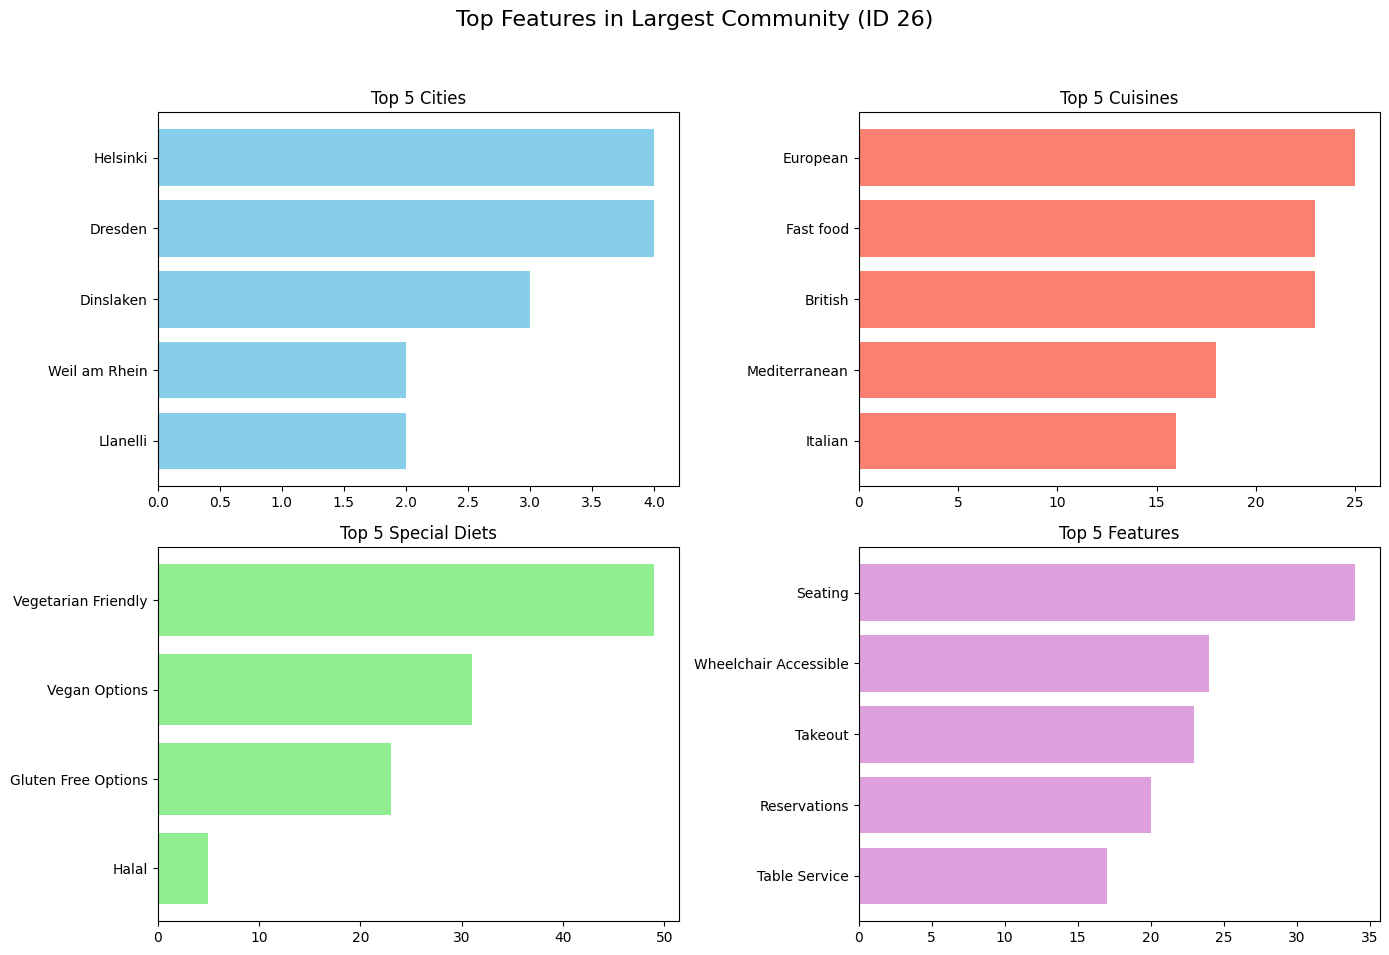

In [67]:
import matplotlib.pyplot as plt
from collections import Counter

# Step 1: Identify the largest community
largest_comm_id = community_unweighted_sizes.idxmax()

# Step 2: Filter for the largest community
largest_comm_df = community_unweighted[community_unweighted['community_unweighted'] == largest_comm_id]
print(f"\nLargest Community ID: {largest_comm_id} ({len(largest_comm_df)} restaurants)")

# Step 3: Reset and extract items (excluding 'Unknown')
def extract_items(column):
    all_items = []
    for item in column:
        if isinstance(item, str) and item.strip() != 'Unknown' and item.strip() != '[]':
            all_items.extend([c.strip() for c in item.split(',')])
        elif isinstance(item, list):
            all_items.extend(item)
    return all_items

# Extract values
cities = extract_items(largest_comm_df['city'])
cuisines = extract_items(largest_comm_df['cuisines'])
special_diets = extract_items(largest_comm_df['special_diets'])
features = extract_items(largest_comm_df['features'])

# Step 4: Plot the top 5 of each
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f"Top Features in Largest Community (ID {largest_comm_id})", fontsize=16)

def plot_bar(ax, data, title, color):
    top_items = Counter(data).most_common(5)
    labels, values = zip(*top_items)
    ax.barh(labels, values, color=color)
    ax.set_title(title)
    ax.invert_yaxis()

plot_bar(axs[0, 0], cities, 'Top 5 Cities', 'skyblue')
plot_bar(axs[0, 1], cuisines, 'Top 5 Cuisines', 'salmon')
plot_bar(axs[1, 0], special_diets, 'Top 5 Special Diets', 'lightgreen')
plot_bar(axs[1, 1], features, 'Top 5 Features', 'plum')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('/kaggle/working/task6_largest_community_top_features.png')
plt.show()


### 7. Task
## Community Detection (Weighted)

- Run the same algorithm on the weighted network.
- Compare community structure between the two versions.

In [68]:
G_weighted = nx.read_gml('/kaggle/working/task2_graph.gml')
df = pd.read_parquet('/kaggle/working/task2_df.parquet')
print(f"Loaded weighted graph: {G_weighted.number_of_nodes()} nodes, {G_weighted.number_of_edges()} edges")
print(f"Loaded DataFrame: {len(df)} rows")


Loaded weighted graph: 4846 nodes, 11238 edges
Loaded DataFrame: 5000 rows


In [69]:

#  Apply Louvain community detection on weighted graph loaded from task 2

community_df_weighted= communityLouvainFuc(G, weight=True)


Detected 2972 communities


In [70]:
community_sizes_weighted = community_df_weighted['community_weighted'].value_counts()
print("\nTop 5 Weighted Communities by Size:")
print(community_sizes_weighted.head())


# Analyze shared features for top 3 communities
cuisines=[]
cities=[]
special_diets=[]
features=[]


top_communities = community_sizes_weighted.head(10).index
print("\nShared Features of Top 3 Communities:")

for comm in top_communities:
    comm_df = community_df_weighted[community_df_weighted['community_weighted'] == comm]
    print(f"\nCommunity {comm} ({len(comm_df)} restaurants):")

    cities += extract_cuisine_items(comm_df['city'])
    print(f"\nTop 5 cities: {Counter(cities).most_common(5)}")
    
    cuisines += extract_cuisine_items(comm_df['cuisines'])
    
    print(f"\nTop 5 cuisines: {Counter(cuisines).most_common(5)}")
    
    special_diets += extract_cuisine_items(comm_df['special_diets'])
    print(f"\nTop 5 special_diets: {Counter(special_diets).most_common(5)}")

    features += extract_cuisine_items(comm_df['features'])
    print(f"\nTop 5 features: {Counter(features).most_common(5)}")




Top 5 Weighted Communities by Size:
community_weighted
26     156
201    102
2       98
44      97
217     60
Name: count, dtype: int64

Shared Features of Top 3 Communities:

Community 26 (156 restaurants):

Top 5 cities: [('Unknown', 113), ('Helsinki', 4), ('Dresden', 4), ('Dinslaken', 3), ('Weil am Rhein', 2)]

Top 5 cuisines: [('European', 25), ('Fast food', 23), ('British', 23), ('Mediterranean', 18), ('Italian', 16)]

Top 5 special_diets: [('Vegetarian Friendly', 49), ('Vegan Options', 31), ('Gluten Free Options', 23), ('Halal', 5)]

Top 5 features: [('Seating', 34), ('Wheelchair Accessible', 24), ('Takeout', 23), ('Reservations', 20), ('Table Service', 17)]

Community 201 (102 restaurants):

Top 5 cities: [('Unknown', 140), ('Frankfurt', 13), ('Dusseldorf', 9), ('Hannover', 5), ('Sheffield', 5)]

Top 5 cuisines: [('European', 39), ('Fast food', 37), ('British', 34), ('Cafe', 29), ('Mediterranean', 23)]

Top 5 special_diets: [('Vegetarian Friendly', 80), ('Vegan Options', 48), (

### Comparision between weighted and unweighted graphs

### extract_cuisine_items

In [71]:
def extract_cuisine_items(column):
    all_cuisines = []
    for item in column:
        if isinstance(item, str) and item.strip() != '[]':
            all_cuisines.extend([c.strip() for c in item.split(',')])
    return all_cuisines


### Jaccard similarity

In [72]:

def jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0


In [73]:
from sklearn.metrics import adjusted_rand_score

# Step 3: Compare unweighted (Task 6) and weighted (Task 7) communities
community_df_unweighted = community_unweighted[['restaurant_name', 'community_unweighted']]
community_sizes_unweighted = community_df_unweighted['community_unweighted'].value_counts()
print("\nComparison of Community Structures:")
print(f"Unweighted (Task 6): {len(set(community_df_unweighted['community_unweighted']))} communities")
print(f"Weighted (Task 7): {len(set(community_df_weighted['community_weighted']))} communities")

print("\nTop 5 Unweighted Community Sizes:")
print(community_sizes_unweighted.head())
print("\nTop 5 Weighted Community Sizes:")
print(community_sizes_weighted.head())

comparison_df = community_unweighted.merge(
    community_df_weighted[['restaurant_name', 'community_weighted']],
    on='restaurant_name',
    how='inner'
)
ari = adjusted_rand_score(community_unweighted['community_unweighted'], community_df_weighted['community_weighted'])
print(f"\nAdjusted Rand Index (ARI): {ari:.4f}")
print("(ARI close to 1: similar partitions; close to 0: dissimilar)")



comparison_cities = []
comparison_cuisines = []



top_communities_unweighted = community_sizes_unweighted.head(3).index
top_communities_weighted = community_sizes_weighted.head(3).index



# Compare shared features of top 3 communities
print("\n=== Shared Features Comparison (Top 3 Communities) ===")
for comm_type, comm_df, top_comms, prefix in [
    ('Unweighted', community_unweighted, top_communities_unweighted, 'community_unweighted'),
    ('Weighted', community_df_weighted, top_communities_weighted, 'community_weighted')
]:
    print(f"\n--- {comm_type} Top 3 Communities ---")
    for comm in top_comms:
        comm_data = comm_df[comm_df[prefix] == comm]
        print(f"\nCommunity {comm} ({len(comm_data)} restaurants):")
        cities = Counter(comm_data['city'].dropna())
        print(f"  Top Cities: {cities.most_common(10)}")
        cuisines = extract_cuisine_items(comm_data['cuisines'])
        cuisine_counts = Counter(cuisines)
        print(f"  Top Cuisines: {cuisine_counts.most_common(5)}")
        # print(f"  Top Cuisines: {cuisines.most_common(5)}")
        
        # special_diets = Counter([sd for sublist in comm_data['special_diets'].dropna() for sd in sublist])
        special_diets = extract_cuisine_items(comm_data['special_diets'])
        special_diets_counts = Counter(special_diets)
        print(f"  Top Special Diets: {special_diets_counts.most_common(5)}")
        # features = Counter([f for sublist in comm_data['features'].dropna() for f in sublist])
        features = extract_cuisine_items(comm_data['features'])
        features_counts = Counter(features)
        print(f"  Top Features: {features_counts.most_common(5)}")







Comparison of Community Structures:
Unweighted (Task 6): 2972 communities
Weighted (Task 7): 2972 communities

Top 5 Unweighted Community Sizes:
community_unweighted
26     156
201    102
2       98
44      97
217     60
Name: count, dtype: int64

Top 5 Weighted Community Sizes:
community_weighted
26     156
201    102
2       98
44      97
217     60
Name: count, dtype: int64

Adjusted Rand Index (ARI): 1.0000
(ARI close to 1: similar partitions; close to 0: dissimilar)

=== Shared Features Comparison (Top 3 Communities) ===

--- Unweighted Top 3 Communities ---

Community 26 (156 restaurants):
  Top Cities: [('Unknown', 113), ('Helsinki', 4), ('Dresden', 4), ('Dinslaken', 3), ('Weil am Rhein', 2), ('Llanelli', 2), ('Backnang', 2), ('Wuppertal', 2), ('Delmenhorst', 2), ('Nuremberg', 2)]
  Top Cuisines: [('European', 25), ('Fast food', 23), ('British', 23), ('Mediterranean', 18), ('Italian', 16)]
  Top Special Diets: [('Vegetarian Friendly', 49), ('Vegan Options', 31), ('Gluten Free O

In [74]:
def extract_cuisine_set(series):
    cuisines = set()
    for item in series.dropna():
        if isinstance(item, str):
            cuisines.update([c.strip() for c in item.split(',')])
        elif isinstance(item, list):
            cuisines.update(item)
    return cuisines


# Compare cuisine overlap between top communities
print("\n=== Cuisine Overlap (Jaccard Similarity) ===\n\n")

for i, (comm_unw, comm_w) in enumerate(zip(top_communities[:1], top_communities_weighted[:1])):
    unw_data = community_unweighted[community_unweighted['community_unweighted'] == comm_unw]
    w_data = community_df_weighted[community_df_weighted['community_weighted'] == comm_w]
    # print("Unweighted Data Columns:", unw_data.columns.tolist())
    # print("Weighted Data Columns:", w_data.columns.tolist())
    # print("Unweighted Data Columns: Cuisines -> ", w_data['cuisines'].head())
    # print("Weighted Data Columns: Cuisines -> ", w_data['cuisines'].head())

    # unw_cuisines = set(c for sublist in unw_data['cuisines'].dropna())
    # w_cuisines = set(c for sublist in w_data['cuisines'].dropna() for c in sublist)
    unw_cuisines = extract_cuisine_set(unw_data['cuisines'])
    w_cuisines = extract_cuisine_set(w_data['cuisines'])
    jaccard = jaccard_similarity(unw_cuisines, w_cuisines)
    print(f"Top Community {i+1} (Unweighted {comm_unw} vs. Weighted {comm_w}): Jaccard Similarity = {jaccard:.4f}")





=== Cuisine Overlap (Jaccard Similarity) ===


Top Community 1 (Unweighted 26 vs. Weighted 26): Jaccard Similarity = 1.0000


In [75]:
# Define a function to prepare top 5 counts for comparison
def get_top_counts(column, n=5):
    return Counter([c for c in column if c != 'Unknown']).most_common(n)

def get_top_from_string(column, n=5):
    return Counter(extract_items(column)).most_common(n)


In [76]:
# Find the community with the most restaurants in unweighted and weighted
largest_comm_unweighted = community_unweighted['community_unweighted'].value_counts().idxmax()
largest_comm_weighted = community_df_weighted['community_weighted'].value_counts().idxmax()

# Extract dataframes
comm_data_unweighted = community_unweighted[community_unweighted['community_unweighted'] == largest_comm_unweighted]
comm_data_weighted = community_df_weighted[community_df_weighted['community_weighted'] == largest_comm_weighted]


In [77]:
def prepare_plot_data(comm_data, label):
    return {
        'cities': get_top_counts(comm_data['city']),
        'cuisines': get_top_from_string(comm_data['cuisines']),
        'special_diets': get_top_from_string(comm_data['special_diets']),
        'features': get_top_from_string(comm_data['features']),
        'label': label
    }

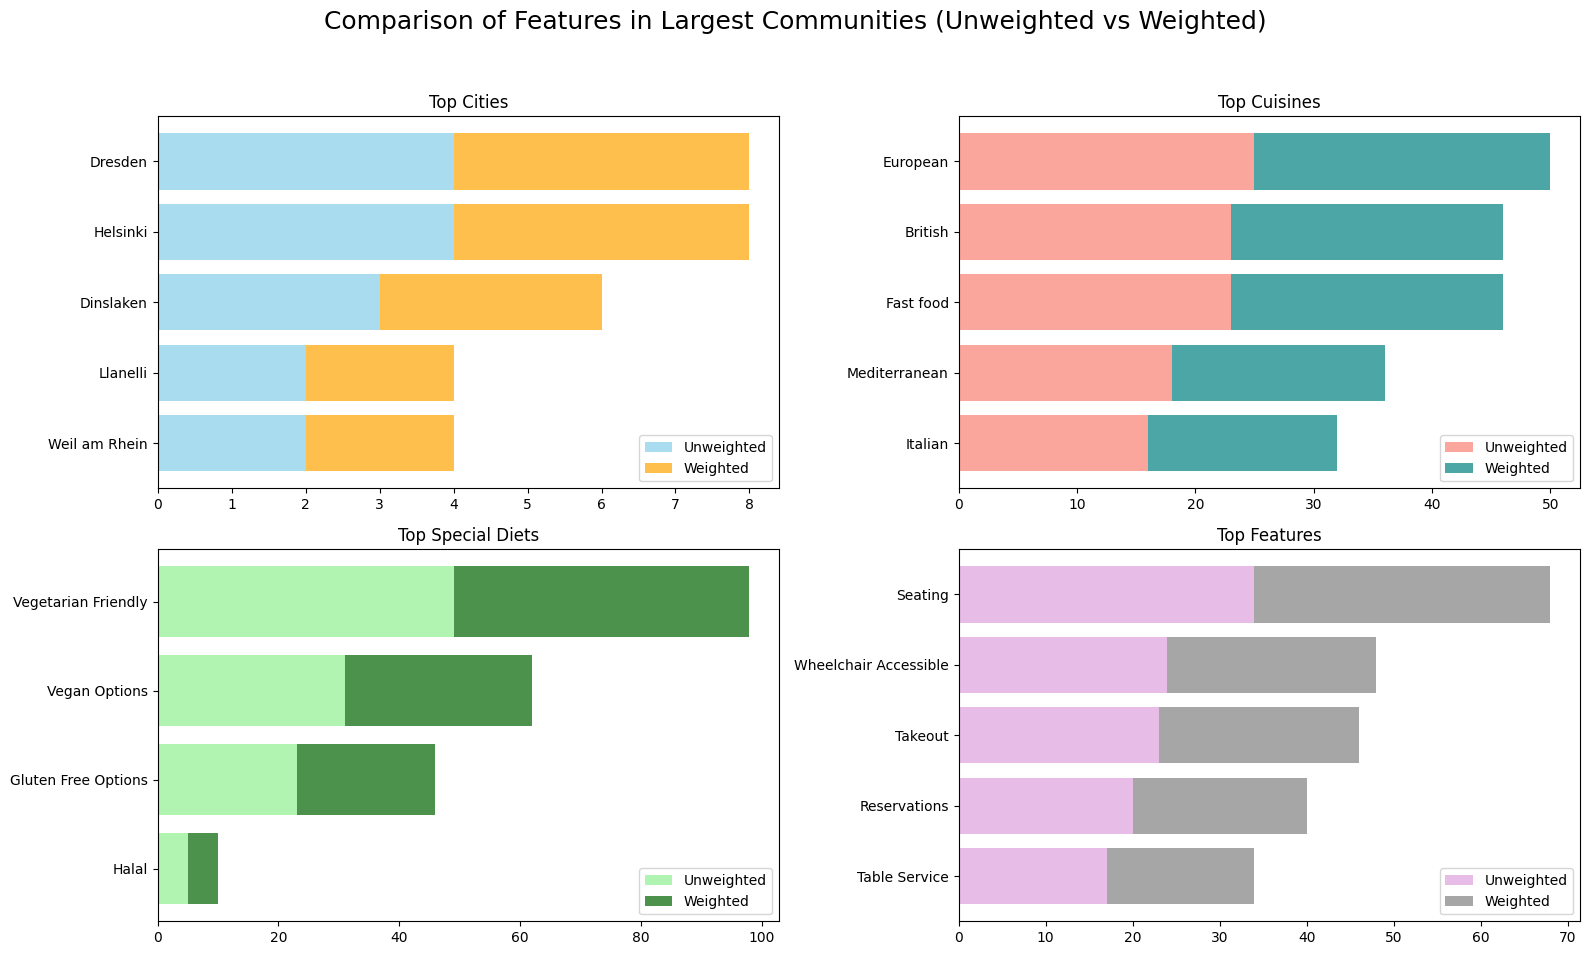

In [78]:


data_unweighted = prepare_plot_data(comm_data_unweighted, "Unweighted")
data_weighted = prepare_plot_data(comm_data_weighted, "Weighted")

# Plot combined bar charts
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(f"Comparison of Features in Largest Communities (Unweighted vs Weighted)", fontsize=18)

def plot_comparison(ax, feature_key, title, color_u, color_w):
    # Unzip items and align by labels
    items_u = dict(data_unweighted[feature_key])
    items_w = dict(data_weighted[feature_key])
    
    # Union of labels to keep consistent comparison
    all_labels = list(set(items_u.keys()).union(items_w.keys()))
    all_labels.sort(key=lambda x: (-(items_u.get(x, 0) + items_w.get(x, 0)), x))  # sort by total frequency

    values_u = [items_u.get(label, 0) for label in all_labels]
    values_w = [items_w.get(label, 0) for label in all_labels]

    ax.barh(all_labels, values_u, color=color_u, label='Unweighted', alpha=0.7)
    ax.barh(all_labels, values_w, color=color_w, left=values_u, label='Weighted', alpha=0.7)
    ax.set_title(title)
    ax.invert_yaxis()
    ax.legend()

plot_comparison(axs[0, 0], 'cities', 'Top Cities', 'skyblue', 'orange')
plot_comparison(axs[0, 1], 'cuisines', 'Top Cuisines', 'salmon', 'teal')
plot_comparison(axs[1, 0], 'special_diets', 'Top Special Diets', 'lightgreen', 'darkgreen')
plot_comparison(axs[1, 1], 'features', 'Top Features', 'plum', 'grey')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('/kaggle/working/task7_Weighted_UnWeighted_Community_Graph_.png')
plt.show()


In [79]:
# Save results
community_df_weighted.to_csv('/kaggle/working/task7_communities.csv', index=False)
# nx.write_gml(G, '/kaggle/working/task7_weighted_graph.gml')
print("Saved community assignments to /kaggle/working/task7_communities.csv and unweighted graph to /kaggle/working/task7_weighted_graph.gml")

Saved community assignments to /kaggle/working/task7_communities.csv and unweighted graph to /kaggle/working/task7_weighted_graph.gml


### 8. Role of Dietary Preferences

- Filter nodes with
  - vegetarian_friendly
  - vegan_options
  - gluten_free tags.
- Analyze their position in the network (e.g., density, centrality, community inclusion).

In [80]:

# Load Task 2 weighted graph, DataFrame, and Task 7 communities
G = nx.read_gml('/kaggle/working/task2_graph.gml')
df = pd.read_parquet('/kaggle/working/task2_df.parquet')
community_df_weighted = pd.read_csv('/kaggle/working/task7_communities.csv')
print(f"Loaded weighted graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Loaded DataFrame: {len(df)} rows")
print(f"Loaded Task 7 communities: {len(community_df_weighted)} restaurants")


Loaded weighted graph: 4846 nodes, 11238 edges
Loaded DataFrame: 5000 rows
Loaded Task 7 communities: 5000 restaurants




### Step 1: Filter nodes with vegetarian_friendly, vegan_options, or gluten_free tags
### Parse special_diets column (stringified lists)

In [81]:

print(df.columns.tolist())

 # Define dietary tags

dietary_tags = ['vegetarian_friendly', 'vegan_options', 'gluten_free']
dietary_nodes = []

# Loop through each dietary tag column
for tag in dietary_tags:
    if tag in df.columns:
        matches = df[df[tag] == 'Y']['restaurant_name'].tolist()
        dietary_nodes.extend(matches)

# Remove duplicates
dietary_nodes = list(set(dietary_nodes))
print(f"\n\n====== \n\n Found  {len(dietary_nodes)} restaurants with dietary tags\n\n======")


['restaurant_name', 'original_location', 'country', 'province', 'city', 'address', 'latitude', 'longitude', 'claimed', 'popularity_detailed', 'popularity_generic', 'top_tags', 'price_range', 'meals', 'cuisines', 'special_diets', 'features', 'vegetarian_friendly', 'vegan_options', 'gluten_free', 'avg_rating', 'total_reviews_count', 'reviews_count_in_default_language', 'excellent', 'very_good', 'average', 'poor', 'food', 'service']



 Found  1585 restaurants with dietary tags



In [82]:

# Step 2: Analyze network position
# Create subgraph of dietary nodes

G_dietary = G.subgraph(dietary_nodes)
print(f"Dietary subgraph: {G_dietary.number_of_nodes()} nodes, {G_dietary.number_of_edges()} edges")

# Density of dietary subgraph
density = nx.density(G_dietary)

full_graph_density = nx.density(G)
print(f"\nDensity Analysis:")
print(f"Dietary subgraph density: {density:.6f}")
print(f"Full graph density: {full_graph_density:.6f}")
print("(Higher density means more connections among dietary restaurants)")

# Centrality in the full graph
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, k=min(1000, G.number_of_nodes()), weight='weight')

# Compute centrality for dietary nodes
dietary_centrality = pd.DataFrame({
    'restaurant_name': dietary_nodes,
    'degree_centrality': [degree_centrality[node] for node in dietary_nodes],
    'betweenness_centrality': [betweenness_centrality[node] for node in dietary_nodes]
})


# Average centrality for dietary vs. all nodes
avg_degree_dietary = dietary_centrality['degree_centrality'].mean()
avg_degree_all = sum(degree_centrality.values()) / len(degree_centrality)
avg_betweenness_dietary = dietary_centrality['betweenness_centrality'].mean()
avg_betweenness_all = sum(betweenness_centrality.values()) / len(betweenness_centrality)

print(f"\nCentrality Analysis:")
print(f"Average degree centrality (dietary): {avg_degree_dietary:.6f}")
print(f"Average degree centrality (all): {avg_degree_all:.6f}")
print(f"Average betweenness centrality (dietary): {avg_betweenness_dietary:.6f}")
print(f"Average betweenness centrality (all): {avg_betweenness_all:.6f}")
print("(Higher centrality means dietary restaurants are more connected or influential)")


Dietary subgraph: 1585 nodes, 1251 edges

Density Analysis:
Dietary subgraph density: 0.000997
Full graph density: 0.000957
(Higher density means more connections among dietary restaurants)

Centrality Analysis:
Average degree centrality (dietary): 0.000972
Average degree centrality (all): 0.000957
Average betweenness centrality (dietary): 0.000013
Average betweenness centrality (all): 0.000011
(Higher centrality means dietary restaurants are more connected or influential)


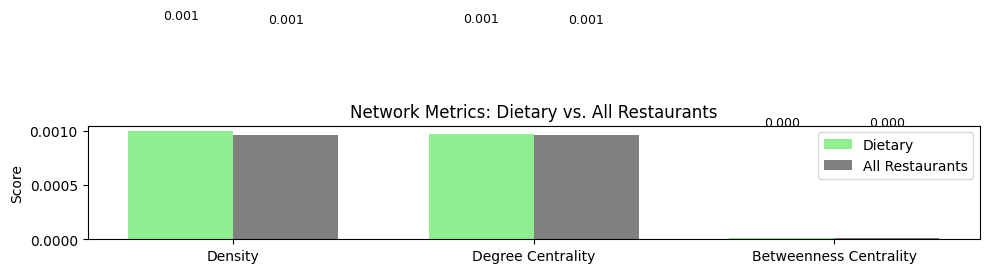

In [83]:


# Data from your analysis
labels = ['Density', 'Degree Centrality', 'Betweenness Centrality']
dietary_vals = [
    density,
    avg_degree_dietary,
    avg_betweenness_dietary
]
all_vals = [
    full_graph_density,
    avg_degree_all,
    avg_betweenness_all
]

x = range(len(labels))
width = 0.35

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([i - width/2 for i in x], dietary_vals, width, label='Dietary', color='lightgreen')
ax.bar([i + width/2 for i in x], all_vals, width, label='All Restaurants', color='gray')

# Labels and aesthetics
ax.set_ylabel('Score')
ax.set_title('Network Metrics: Dietary vs. All Restaurants')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotate bars
for i in x:
    ax.text(i - width/2, dietary_vals[i] + 0.001, f"{dietary_vals[i]:.3f}", ha='center', va='bottom', fontsize=9)
    ax.text(i + width/2, all_vals[i] + 0.001, f"{all_vals[i]:.3f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('/kaggle/working/task8_NetworkMetric_plot.png')
plt.show()


In [84]:

# Top 5 dietary nodes by centrality
print(f"\nTop 5 Dietary Restaurants by Degree Centrality:")
print(dietary_centrality.sort_values('degree_centrality', ascending=False)[['restaurant_name', 'degree_centrality']].head())
print(f"\nTop 5 Dietary Restaurants by Betweenness Centrality:")
print(dietary_centrality.sort_values('betweenness_centrality', ascending=False)[['restaurant_name', 'betweenness_centrality']].head())

# Community inclusion (using Task 7 weighted communities)
dietary_communities = community_df_weighted[community_df_weighted['restaurant_name'].isin(dietary_nodes)]
community_distribution = dietary_communities['community_weighted'].value_counts()
print(f"\nCommunity Inclusion Analysis:")
print(f"Dietary restaurants in Task 7 communities (top 3):")
print(community_distribution.head())
print(f"Total communities with dietary restaurants: {len(community_distribution)}")

# Analyze dietary tags per community


# from collections import Counter

# Define dietary tags
# dietary_tags = ['vegetarian_friendly', 'vegan_options', 'gluten_free']

print("\n=== Dietary Tags in Top 3 Communities ===")
top_communities = community_df_weighted['community_weighted'].value_counts().head(3).index

for comm in top_communities:
    # Filter the community
    comm_df = community_df_weighted[community_df_weighted['community_weighted'] == comm]
    
    # Find all restaurant names in this community
    comm_nodes = comm_df['restaurant_name'].tolist()
    
    # Initialize tag counter
    tag_counter = Counter()
    
    # For each tag, check which restaurants in this community have 'Y'
    for tag in dietary_tags:
        # Get restaurant names where the tag is 'Y'
        y_nodes = df[df[tag] == 'Y']['restaurant_name']
        
        # Count how many of those nodes are in the current community
        count = sum(name in comm_nodes for name in y_nodes)
        tag_counter[tag] = count

    print(f"\nCommunity {comm} ({len(comm_df)} total restaurants):")
    for tag, count in tag_counter.items():
        print(f"  {tag}: {count} restaurants with '{tag}' = Y")

# print(dietary_centrality.isna().mean()*100)




Top 5 Dietary Restaurants by Degree Centrality:
         restaurant_name  degree_centrality
1091       Pret a Manger           0.016718
865         Café Etienne           0.015067
1175       Le Gribouille           0.014861
133             Angelina           0.014654
1096  Restaurant Sannine           0.014448

Top 5 Dietary Restaurants by Betweenness Centrality:
           restaurant_name  betweenness_centrality
1091         Pret a Manger                0.003580
841   Bread Street Kitchen                0.002978
1363        Domino's Pizza                0.002631
1149         Mudec Bistrot                0.001492
499           Ugarit Sants                0.001348

Community Inclusion Analysis:
Dietary restaurants in Task 7 communities (top 3):
community_weighted
26     51
201    31
2      27
44     25
217    23
Name: count, dtype: int64
Total communities with dietary restaurants: 1133

=== Dietary Tags in Top 3 Communities ===

Community 26 (156 total restaurants):
  vegetarian_friend

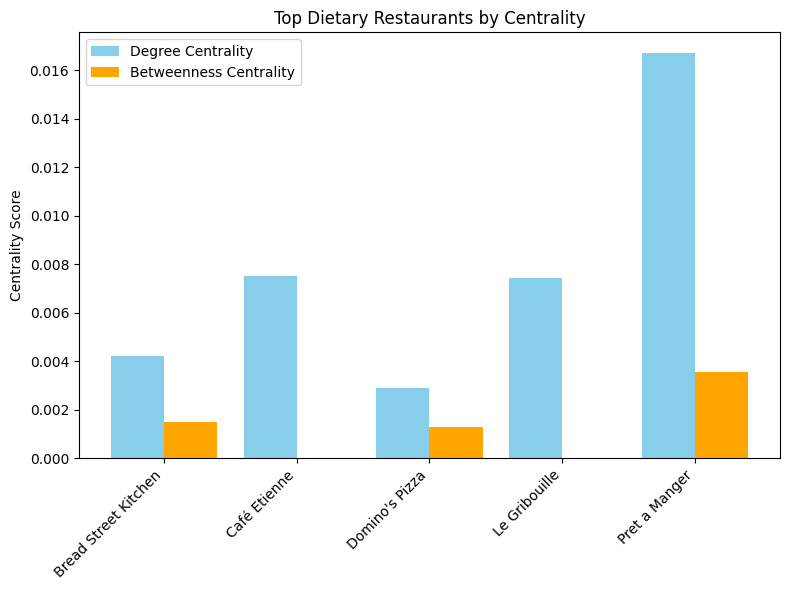

In [85]:
# Get top 5 by degree and betweenness centrality




top_degree = dietary_centrality.sort_values('degree_centrality', ascending=False).head(3)
top_betweenness = dietary_centrality.sort_values('betweenness_centrality', ascending=False).head(3)


# Merge both on restaurant name (in case overlap)
top_combined = pd.merge(top_degree, top_betweenness, on='restaurant_name', how='outer')

top_combined.fillna(0.0, inplace=True)  # Replace NaN with 0 (or any other value you prefer)


# Extract columns dynamically
degree_columns = [col for col in top_combined.columns if 'degree_centrality' in col]
betweenness_columns = [col for col in top_combined.columns if 'betweenness_centrality' in col]

# Merge degree centrality and betweenness centrality, filling NaN values with 0
top_combined['degree_centrality'] = top_combined[degree_columns].fillna(0).mean(axis=1)  # Averaging both degree columns
top_combined['betweenness_centrality'] = top_combined[betweenness_columns].fillna(0).mean(axis=1)  # Averaging both betweenness columns

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
x = range(len(top_combined))

# Plot bars for degree and betweenness centrality
ax.bar(x, top_combined['degree_centrality'], width=0.4, label='Degree Centrality', color='skyblue')
ax.bar([i + 0.4 for i in x], top_combined['betweenness_centrality'], width=0.4, label='Betweenness Centrality', color='orange')

# Set the x-ticks and labels
ax.set_xticks([i + 0.2 for i in x])
ax.set_xticklabels(top_combined['restaurant_name'], rotation=45, ha='right')

# Title, labels, and legend
ax.set_title('Top Dietary Restaurants by Centrality')
ax.set_ylabel('Centrality Score')
ax.legend()

# Layout adjustment and display
plt.tight_layout()
plt.savefig("/kaggle/working/task8_Dietary_graph.png")
plt.show()






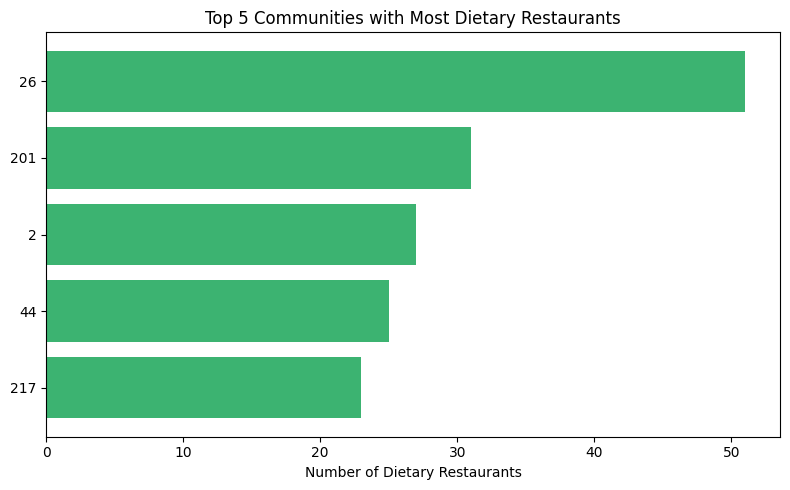

In [86]:
# Plot top 5 community distributions
top_community_dist = community_distribution.head(5)
top_community_dist = top_community_dist.sort_values(ascending=True)  # horizontal bars

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(top_community_dist.index.astype(str), top_community_dist.values, color='mediumseagreen')
ax.set_xlabel('Number of Dietary Restaurants')
ax.set_title('Top 5 Communities with Most Dietary Restaurants')
plt.tight_layout()
plt.savefig("/kaggle/working/task8_Top_Community_Dietary_Restaurants.png")
plt.show()


In [87]:
# Collect dietary tag counts for each community
tag_data = []

for comm in top_communities:
    comm_df = community_df_weighted[community_df_weighted['community_weighted'] == comm]
    comm_nodes = comm_df['restaurant_name'].tolist()
    tag_counter = Counter()

    for tag in dietary_tags:
        y_nodes = df[df[tag] == 'Y']['restaurant_name']
        count = sum(name in comm_nodes for name in y_nodes)
        tag_counter[tag] = count

    tag_data.append({
        'community': comm,
        **tag_counter
    })

# Create DataFrame
tag_df = pd.DataFrame(tag_data)
tag_df.set_index('community', inplace=True)


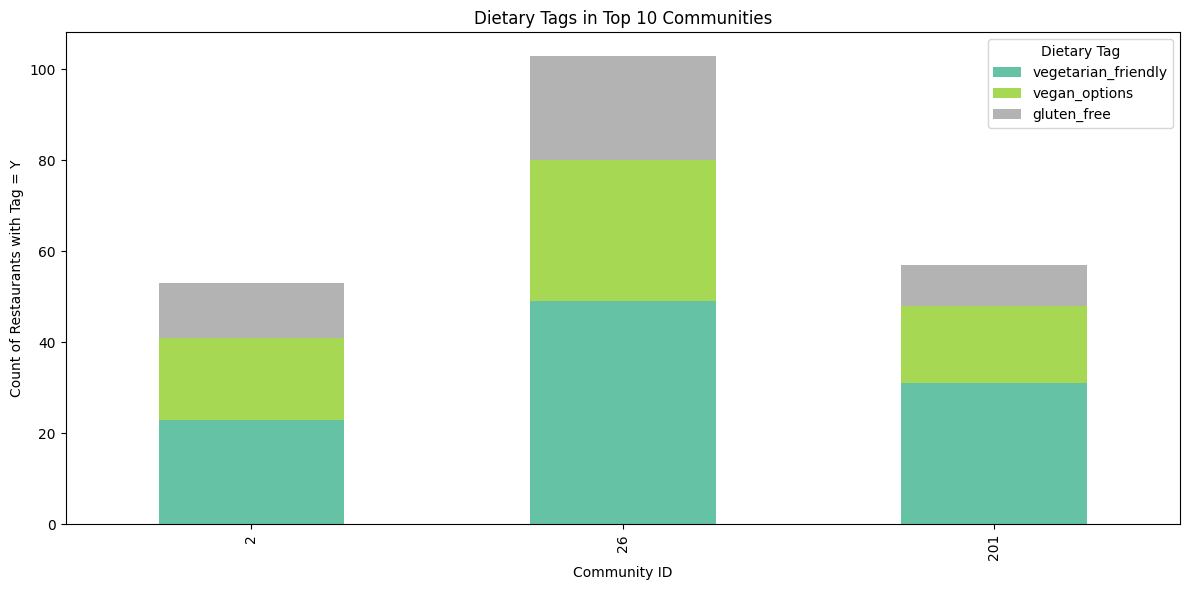

In [88]:
# Plot stacked bar chart
tag_df_sorted = tag_df.sort_index()  # optional sorting

ax = tag_df_sorted.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
ax.set_title('Dietary Tags in Top 10 Communities')
ax.set_xlabel('Community ID')
ax.set_ylabel('Count of Restaurants with Tag = Y')
ax.legend(title='Dietary Tag')
plt.tight_layout()
plt.savefig("/kaggle/working/task8_Dietary_tags.png")
plt.show()


In [89]:
dietary_centrality.to_csv('/kaggle/working/task8_dietary_analysis.csv', index=False)
print("Saved analysis to /kaggle/working/task8_dietary_analysis.csv")

Saved analysis to /kaggle/working/task8_dietary_analysis.csv


### 9. Subnetwork Analysis by Region
- Extract subnetworks by city or country.
- Compare SNA statistics: density, diameter, clustering coefficient.

In [90]:
# Load Task 2 graph and DataFrame
G = nx.read_gml('/kaggle/working/task2_graph.gml')
df = pd.read_parquet('/kaggle/working/task2_df.parquet')
print(f"Loaded graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Loaded DataFrame: {len(df)} rows")


Loaded graph: 4846 nodes, 11238 edges
Loaded DataFrame: 5000 rows


In [91]:

# Step 1: Extract subnetworks by city
# Check available columns
print("DataFrame columns:", df.columns.tolist())

# Verify city column exists
if 'city' not in df.columns:
    raise KeyError("Column 'city' not found in task2_df.parquet. Please check the DataFrame.")

# Get top 10 cities by restaurant count
city_counts = df['city'].value_counts()
top_cities = city_counts.head(10).index.tolist()
print(f"Top 10 cities by restaurant count:\n{city_counts.head(10)}")

# Create subnetworks for top cities
subgraphs = {}
for city in top_cities:
    # Get restaurant names in this city
    city_nodes = df[df['city'] == city]['restaurant_name'].tolist()
    # Filter nodes that exist in the graph
    city_nodes = [node for node in city_nodes if node in G.nodes()]
    # Create subgraph
    subgraph = G.subgraph(city_nodes)
    subgraphs[city] = subgraph
    print(f"Subgraph for {city}: {subgraph.number_of_nodes()} nodes, {subgraph.number_of_edges()} edges")


DataFrame columns: ['restaurant_name', 'original_location', 'country', 'province', 'city', 'address', 'latitude', 'longitude', 'claimed', 'popularity_detailed', 'popularity_generic', 'top_tags', 'price_range', 'meals', 'cuisines', 'special_diets', 'features', 'vegetarian_friendly', 'vegan_options', 'gluten_free', 'avg_rating', 'total_reviews_count', 'reviews_count_in_default_language', 'excellent', 'very_good', 'average', 'poor', 'food', 'service']
Top 10 cities by restaurant count:
city
Unknown      1831
Paris          79
Madrid         53
Rome           49
Milan          45
Prague         29
Vienna         23
Amsterdam      22
Lisbon         21
Munich         18
Name: count, dtype: int64
Subgraph for Unknown: 1807 nodes, 4365 edges
Subgraph for Paris: 79 nodes, 2280 edges
Subgraph for Madrid: 53 nodes, 797 edges
Subgraph for Rome: 49 nodes, 353 edges
Subgraph for Milan: 45 nodes, 758 edges
Subgraph for Prague: 29 nodes, 196 edges
Subgraph for Vienna: 23 nodes, 144 edges
Subgraph for 


SNA Statistics for Top Cities:
        city  nodes  edges   density  diameter  clustering_coefficient
0    Unknown   1807   4365  0.002675        11                0.200534
1      Paris     79   2280  0.740019         3                0.447063
2     Madrid     53    797  0.578374         6                0.472787
3       Rome     49    353  0.300170         6                0.340423
4      Milan     45    758  0.765657         3                0.506685
5     Prague     29    196  0.482759         4                0.517521
6     Vienna     23    144  0.569170         3                0.427037
7  Amsterdam     22    212  0.917749         2                0.532416
8     Lisbon     21    178  0.847619         2                0.545909
9     Munich     18     97  0.633987         2                0.378110


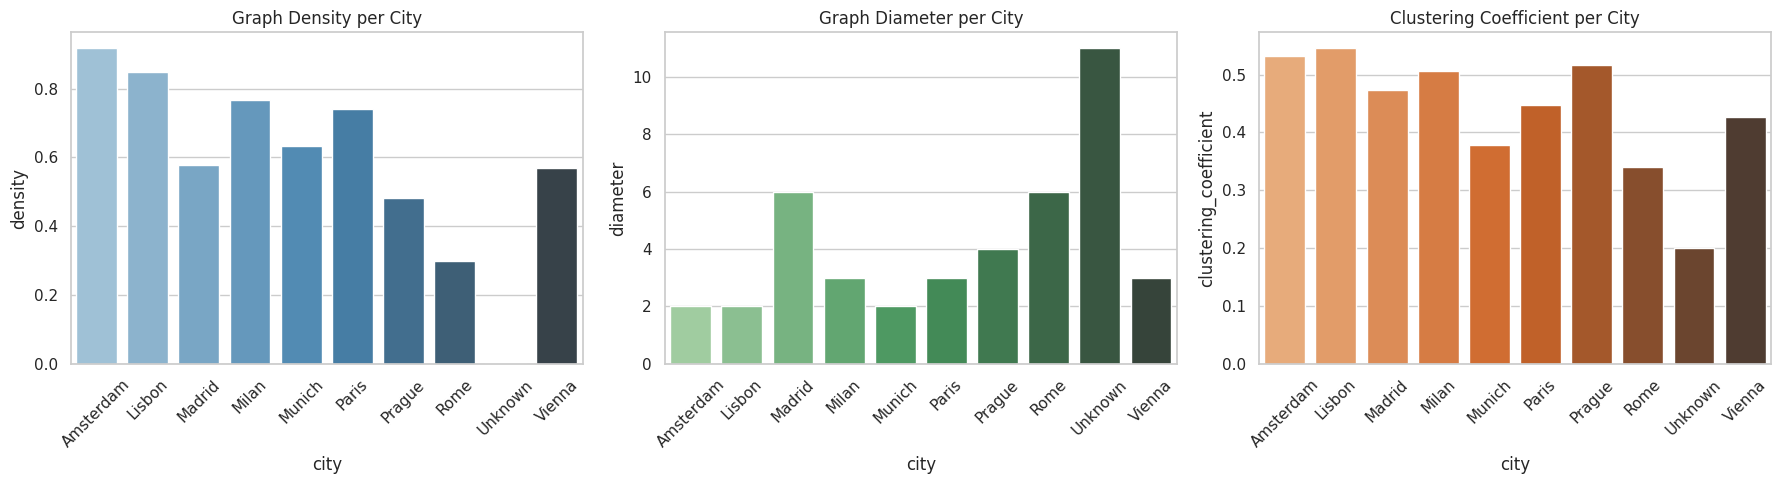

In [92]:
# Step 2: Compute SNA statistics
sna_stats = []
for city, subgraph in subgraphs.items():
    if subgraph.number_of_nodes() == 0:
        continue
    # Density
    density = nx.density(subgraph) if subgraph.number_of_nodes() > 1 else 0
    # Diameter (use largest connected component)
    try:
        components = list(nx.connected_components(subgraph))
        if components:
            largest_cc = max(components, key=len)
            subgraph_cc = subgraph.subgraph(largest_cc)
            diameter = nx.diameter(subgraph_cc) if subgraph_cc.number_of_nodes() > 1 else 0
        else:
            diameter = 0
    except:
        diameter = 0
    # Clustering coefficient (weighted)
    clustering = nx.average_clustering(subgraph, weight='weight') if subgraph.number_of_nodes() > 1 else 0
    sna_stats.append({
        'city': city,
        'nodes': subgraph.number_of_nodes(),
        'edges': subgraph.number_of_edges(),
        'density': density,
        'diameter': diameter,
        'clustering_coefficient': clustering
    })

# Create DataFrame for SNA stats
sna_df = pd.DataFrame(sna_stats)
print("\nSNA Statistics for Top Cities:")
print(sna_df)


sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Sort cities for consistent plotting
sna_df_sorted = sna_df.sort_values('city')

# Density Plot
sns.barplot(data=sna_df_sorted, x='city', y='density', ax=axes[0], palette='Blues_d')
axes[0].set_title('Graph Density per City')
axes[0].tick_params(axis='x', rotation=45)

# Diameter Plot
sns.barplot(data=sna_df_sorted, x='city', y='diameter', ax=axes[1], palette='Greens_d')
axes[1].set_title('Graph Diameter per City')
axes[1].tick_params(axis='x', rotation=45)

# Clustering Coefficient Plot
sns.barplot(data=sna_df_sorted, x='city', y='clustering_coefficient', ax=axes[2], palette='Oranges_d')
axes[2].set_title('Clustering Coefficient per City')
axes[2].tick_params(axis='x', rotation=45)

# Layout adjustment
plt.tight_layout()
plt.savefig('/kaggle/working/task9_subnetwork_plot.png')
plt.show()

In [93]:
# Save SNA stats
sna_df.to_csv('/kaggle/working/task9_sna_stats.csv', index=False)
print("Saved SNA statistics to /kaggle/working/task9_sna_stats.csv")

Saved SNA statistics to /kaggle/working/task9_sna_stats.csv


### 10. Visualization of the Global Network
- Visualize the full network with:
  - Node color = community
  - Node size = total reviews or rating
  - Edge width = weight

In [94]:

G = nx.read_gml('/kaggle/working/task2_graph.gml')
df = pd.read_parquet('/kaggle/working/task2_df.parquet')
community_df = pd.read_csv('/kaggle/working/task7_communities.csv')
print(f"Loaded graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Loaded DataFrame: {len(df)} rows")
print(f"Loaded communities: {len(community_df)} restaurants")


Loaded graph: 4846 nodes, 11238 edges
Loaded DataFrame: 5000 rows
Loaded communities: 5000 restaurants


In [95]:

# Verify required columns
print("DataFrame columns:", df.columns.tolist())
# print("Community DataFrame columns:", community_df.columns.tolist())
if 'total_reviews' in df.columns:
    print("Warning: 'total_reviews' found. Using uniform node sizes.")
if 'community_weighted' in community_df.columns:
    print("Column community_weighted found in task7_communities.csv.")


DataFrame columns: ['restaurant_name', 'original_location', 'country', 'province', 'city', 'address', 'latitude', 'longitude', 'claimed', 'popularity_detailed', 'popularity_generic', 'top_tags', 'price_range', 'meals', 'cuisines', 'special_diets', 'features', 'vegetarian_friendly', 'vegan_options', 'gluten_free', 'avg_rating', 'total_reviews_count', 'reviews_count_in_default_language', 'excellent', 'very_good', 'average', 'poor', 'food', 'service']
Column community_weighted found in task7_communities.csv.


In [96]:
# Step 1: Merge community data with DataFrame
df = df.merge(community_df[['restaurant_name', 'community_weighted']], on='restaurant_name', how='left')
print(f"Merged DataFrame: {len(df)} rows")


Merged DataFrame: 7098 rows


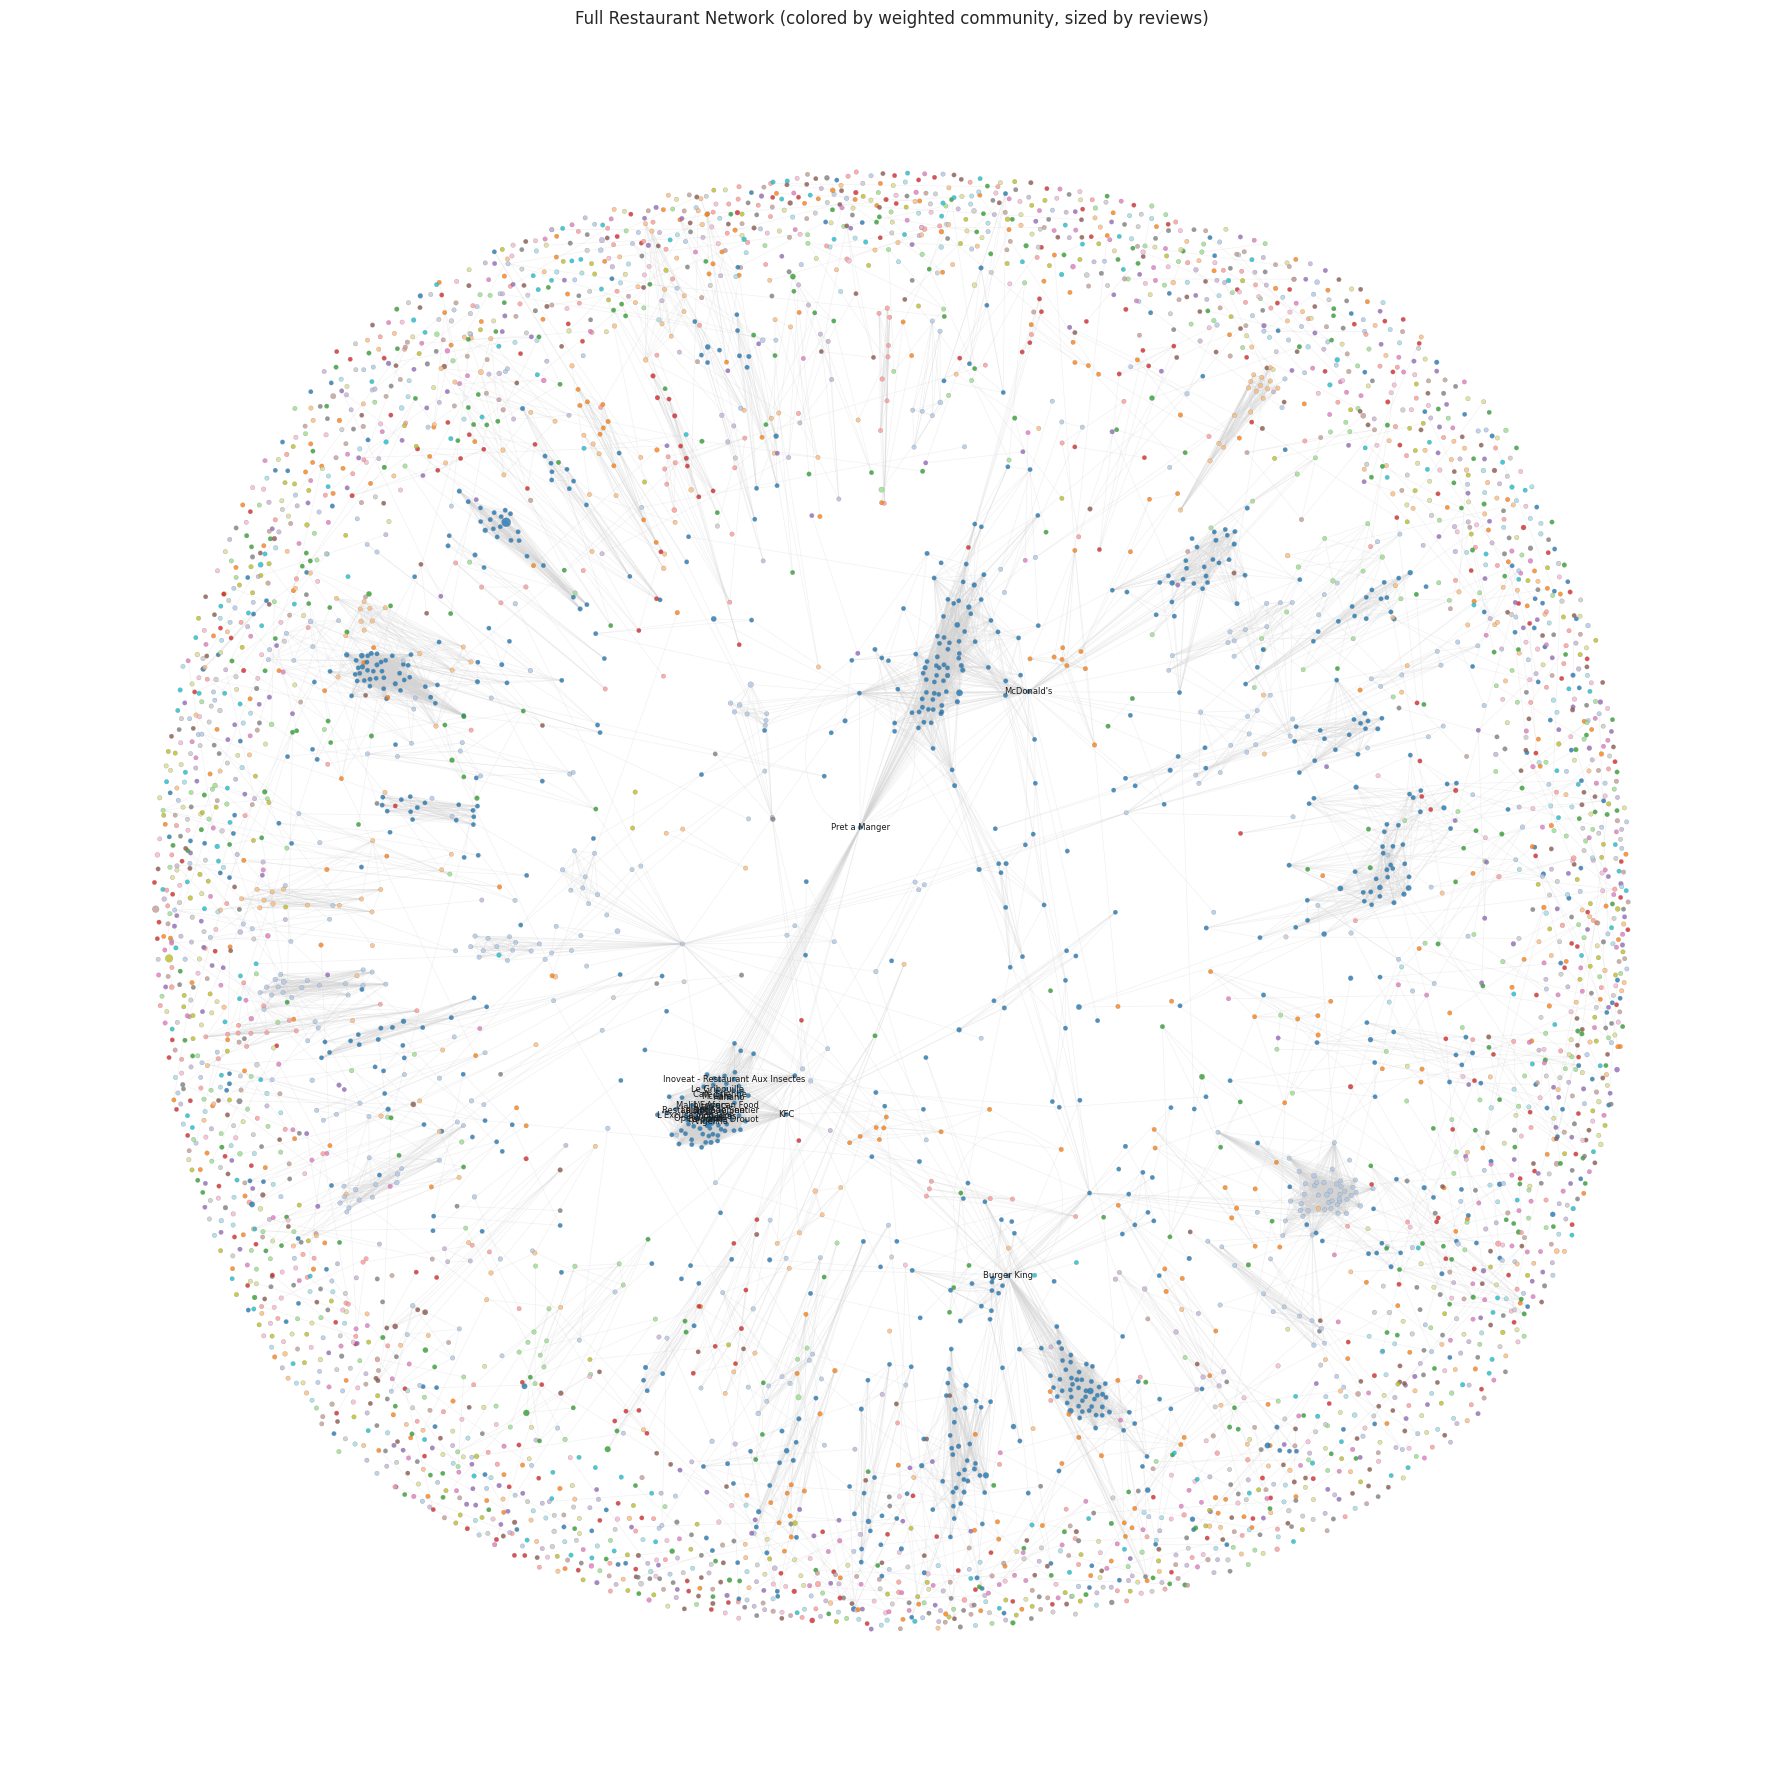

In [97]:

import matplotlib.colors as mcolors

# 1) Build the full subgraph (all nodes in df)
all_nodes = df['restaurant_name'].tolist()
G_full = G.subgraph(all_nodes)

# 2) Prepare color map for communities
communities = df['community_weighted'].dropna().unique()
n_comms = len(communities)
cmap = plt.get_cmap('tab20', n_comms)
comm_to_color = {comm: mcolors.to_hex(cmap(i)) for i, comm in enumerate(communities)}
default_color = '#cccccc'

# 3) Prepare node sizes (scale reviews to [10, 50])
if 'total_reviews_count' in df.columns:
    rev = df['total_reviews_count'].fillna(0)
    mn, mx = rev.min(), rev.max()
    scale = lambda x: 10 + 40*(x - mn)/(mx - mn) if mx>mn else 20
else:
    scale = lambda x: 20

# 4) Build position layout once
pos = nx.spring_layout(G_full, seed=42, k=0.15)

# 5) Draw
plt.figure(figsize=(18, 18))
# edges
nx.draw_networkx_edges(
    G_full, pos,
    edge_color='lightgray',
    alpha=0.3,
    width=0.5
)
# nodes
node_colors = []
node_sizes  = []
for node in G_full.nodes():
    row = df[df['restaurant_name']==node]
    if not row.empty:
        comm = row['community_weighted'].iloc[0]
        node_colors.append(comm_to_color.get(comm, default_color))
        node_sizes.append(scale(row['total_reviews_count'].iloc[0]))
    else:
        node_colors.append(default_color)
        node_sizes.append(20)

nx.draw_networkx_nodes(
    G_full, pos,
    node_size=node_sizes,
    node_color=node_colors,
    linewidths=0.2,
    edgecolors='gray',
    alpha=0.8
)

# optionally draw labels for a few high-degree nodes
high_deg = sorted(G_full.degree(), key=lambda x: x[1], reverse=True)[:20]
labels = {n: n for n, _ in high_deg}
nx.draw_networkx_labels(G_full, pos, labels, font_size=6)

plt.title("Full Restaurant Network (colored by weighted community, sized by reviews)")
plt.axis('off')
plt.tight_layout()
plt.savefig('/kaggle/working/task10_global_network.png')
plt.show()


### 11. Keyword Similarity Network
- Build a separate network using similarity between keywords (e.g., using TF-IDF or cosine similarity).
- Link restaurants with similar descriptions and analyze communities in this network.

In [98]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from community import community_louvain

In [99]:

df = pd.read_parquet('/kaggle/working/task2_df.parquet')
print(f"Loaded DataFrame: {len(df)} rows")

# Verify columns
print("DataFrame columns:", df.columns.tolist())

Loaded DataFrame: 5000 rows
DataFrame columns: ['restaurant_name', 'original_location', 'country', 'province', 'city', 'address', 'latitude', 'longitude', 'claimed', 'popularity_detailed', 'popularity_generic', 'top_tags', 'price_range', 'meals', 'cuisines', 'special_diets', 'features', 'vegetarian_friendly', 'vegan_options', 'gluten_free', 'avg_rating', 'total_reviews_count', 'reviews_count_in_default_language', 'excellent', 'very_good', 'average', 'poor', 'food', 'service']


In [159]:
# Verify columns
print("DataFrame columns:", df.columns.tolist())

# Step 1: Prepare text data
# Use 'special_diets' and 'cuisines' for richer text
required_columns = ['restaurant_name', 'special_diets', 'cuisines']
for col in required_columns:
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not found in task2_df.parquet.")

# Sample 5,000 restaurants (full dataset in this case)
sample_size = 5000
if len(df) > sample_size:
    df_sample = df.sample(n=sample_size, random_state=42)
else:
    df_sample = df
df_sample = df_sample.reset_index(drop=True)  # Ensure sequential indices
print(f"Sampled DataFrame: {len(df_sample)} rows")

# Clean and preprocess text
def preprocess_text(text):
    if pd.isna(text):
        return ""
    if isinstance(text, list):
        text = ", ".join(text)
    return str(text).lower()

df_sample['text'] = df_sample[['special_diets', 'cuisines']].apply(
    lambda x: ' '.join(x.dropna().astype(str)), axis=1
).apply(preprocess_text)
print("Preprocessed text data")


DataFrame columns: ['restaurant_name', 'original_location', 'country', 'province', 'city', 'address', 'latitude', 'longitude', 'claimed', 'popularity_detailed', 'popularity_generic', 'top_tags', 'price_range', 'meals', 'cuisines', 'special_diets', 'features', 'vegetarian_friendly', 'vegan_options', 'gluten_free', 'avg_rating', 'total_reviews_count', 'reviews_count_in_default_language', 'excellent', 'very_good', 'average', 'poor', 'food', 'service']
Sampled DataFrame: 5000 rows
Preprocessed text data


### Compute TF-IDF and cosine similarity

In [160]:
# Step 2: Compute TF-IDF and cosine similarity
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_sample['text'])
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix)
print(f"Cosine similarity matrix shape: {cosine_sim.shape}")



TF-IDF matrix shape: (5000, 138)
Cosine similarity matrix shape: (5000, 5000)


In [161]:
# Step 3: Build similarity network
G = nx.Graph()
similarity_threshold = 0.3  # Reduced to balance edge density

# Add nodes
for idx, row in df_sample.iterrows():
    G.add_node(row['restaurant_name'])

# Add edges
for i in range(len(cosine_sim)):
    for j in range(i + 1, len(cosine_sim)):
        sim_score = cosine_sim[i, j]
        if sim_score > similarity_threshold:
            restaurant_i = df_sample.iloc[i]['restaurant_name']
            restaurant_j = df_sample.iloc[j]['restaurant_name']
            G.add_edge(restaurant_i, restaurant_j, weight=sim_score)

print(f"Similarity network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


Similarity network: 4846 nodes, 1228947 edges


In [162]:
# Step 4: Detect communities
partition = community_louvain.best_partition(G, weight='weight', resolution=0.8, random_state=42)
communities = {}
for node, comm_id in partition.items():
    if comm_id not in communities:
        communities[comm_id] = []
    communities[comm_id].append(node)

print(f"Detected {len(communities)} communities")


Detected 676 communities


In [163]:
# Step 5: Analyze communities
# Create community DataFrame
comm_df = pd.DataFrame({
    'restaurant_name': partition.keys(),
    'community': partition.values()
})

# Summarize community sizes
comm_sizes = pd.Series(partition.values()).value_counts().reset_index()
comm_sizes.columns = ['community', 'size']

# Extract top keywords per community
feature_names = vectorizer.get_feature_names_out()
community_keywords = []
for comm_id in communities:
    comm_nodes = communities[comm_id]
    # Map restaurant names to positional indices
    comm_indices = df_sample.index[df_sample['restaurant_name'].isin(comm_nodes)].tolist()
    if not comm_indices:
        continue  # Skip empty communities
    # Sum TF-IDF scores
    comm_tfidf = tfidf_matrix[comm_indices].sum(axis=0).A1
    # Get top 5 keywords
    top_indices = comm_tfidf.argsort()[-5:][::-1]
    top_keywords = [feature_names[idx] for idx in top_indices]
    community_keywords.append({
        'community': comm_id,
        'size': len(comm_nodes),
        'top_keywords': ", ".join(top_keywords)
    })

comm_summary = pd.DataFrame(community_keywords)
print("\nCommunity Summary:")
print(comm_summary)



Community Summary:
     community  size                                       top_keywords
0            4   890     french, european, german, friendly, vegetarian
1            1   828  italian, pizza, friendly, vegetarian, mediterr...
2            2   437  spanish, mediterranean, greek, friendly, veget...
3            3     1       afghani, zealand, barbecue, bar, bangladeshi
4          118   846         options, vegan, vegetarian, friendly, free
..         ...   ...                                                ...
671         47     1       afghani, zealand, barbecue, bar, bangladeshi
672         21     1       afghani, zealand, barbecue, bar, bangladeshi
673         23     1       afghani, zealand, barbecue, bar, bangladeshi
674         26     1       afghani, zealand, barbecue, bar, bangladeshi
675         27     1       afghani, zealand, barbecue, bar, bangladeshi

[676 rows x 3 columns]


Visualization subgraph: 300 nodes, 4812 edges


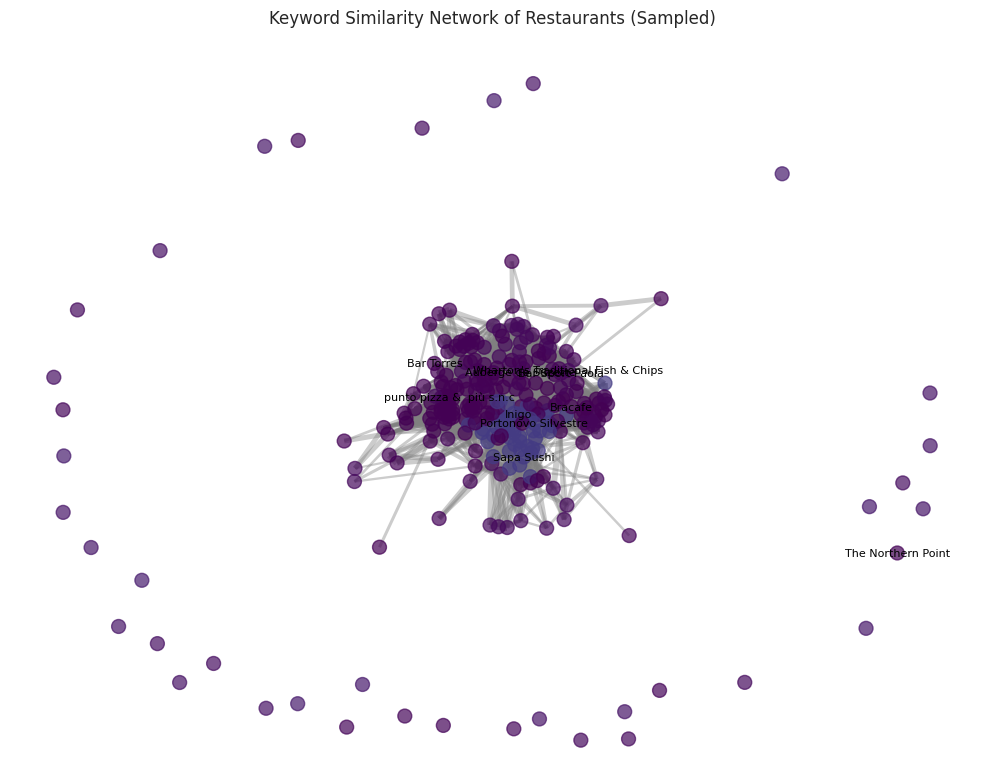

In [167]:

# Step 6: Visualize a sampled subgraph using Matplotlib
def visualize_similarity_network_matplotlib(graph, partition, sample_size=300):
    """
    Visualize a sampled subgraph using Matplotlib.
    
    Parameters:
    - graph: NetworkX graph object
    - partition: Dictionary mapping nodes to their community IDs
    - sample_size: Number of nodes to sample for visualization (default: 300)
    """
    # Sample a subgraph to make visualization manageable
    sample_nodes = list(graph.nodes())[:min(sample_size, graph.number_of_nodes())]
    G_sample = graph.subgraph(sample_nodes)
    print(f"Visualization subgraph: {G_sample.number_of_nodes()} nodes, {G_sample.number_of_edges()} edges")

    # Use spring layout for positioning nodes
    pos = nx.spring_layout(G_sample, seed=42, k=0.15)  # k controls node spacing

    # Prepare colors for communities
    unique_comms = set(partition.values())
    color_map = plt.get_cmap('viridis')  # Use viridis colormap
    comm_to_color = {comm: mcolors.to_hex(color_map(i / max(len(unique_comms), 1))) 
                     for i, comm in enumerate(unique_comms)}

    # Assign colors to nodes based on their community
    node_colors = [comm_to_color.get(partition.get(node, -1), '#888888') for node in G_sample.nodes()]

    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Draw nodes
    nx.draw_networkx_nodes(G_sample, pos, node_color=node_colors, node_size=100, alpha=0.7)

    # Draw edges with widths proportional to similarity weights
    edge_widths = [d['weight'] * 5 for (u, v, d) in G_sample.edges(data=True)]  # Scale weights for visibility
    nx.draw_networkx_edges(G_sample, pos, width=edge_widths, alpha=0.4, edge_color='gray')

    # Draw labels for a subset of nodes to avoid clutter
    labels = {node: node for node in sample_nodes[:10]}  # Label only the first 10 nodes
    nx.draw_networkx_labels(G_sample, pos, labels, font_size=8, font_color='black')

    # Add title and remove axes
    plt.title("Keyword Similarity Network of Restaurants (Sampled)", fontsize=12, pad=20)
    plt.axis('off')  # Hide axes for a cleaner look

    # Save and display the plot
    plt.tight_layout()
    plt.savefig("/kaggle/working/task11_similarity_network.png", dpi=300, bbox_inches='tight')
    plt.show()
    # print("Visualization saved to ./task11_similarity_network.png")

# Call the visualization function
visualize_similarity_network_matplotlib(G, partition)


In [168]:

# Step 7: Save outputs
nx.write_gml(G, '/kaggle/working/task11_similarity_graph.gml')
comm_df.to_csv('/kaggle/working/task11_communities.csv', index=False)
comm_summary.to_csv('/kaggle/working/task11_community_summary.csv', index=False)
print("Saved similarity graph to /kaggle/working/task11_similarity_graph.gml")
print("Saved community assignments to /kaggle/working/task11_communities.csv")
print("Saved community summary to /kaggle/working/task11_community_summary.csv")


Saved similarity graph to /kaggle/working/task11_similarity_graph.gml
Saved community assignments to /kaggle/working/task11_communities.csv
Saved community summary to /kaggle/working/task11_community_summary.csv


### 12. Backbone Extraction
- Use techniques like disparity filtering to extract the most informative subnetwork.
- Analyze and visualize the resulting structure.

In [ ]:
# Load Task 11 similarity graph
G = nx.read_gml('/kaggle/working/task11_similarity_graph.gml')
print(f"Loaded graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


In [169]:

# Debug: Check edge weight distribution
weights = [G[u][v]['weight'] for u, v in G.edges() if 'weight' in G[u][v]]
print(f"Edge weight stats: min={min(weights):.4f}, max={max(weights):.4f}, mean={np.mean(weights):.4f}, std={np.std(weights):.4f}")


comm_df = pd.read_csv('/kaggle/working/task11_communities.csv')
print(f"Loaded communities: {len(comm_df)} restaurants")

df = pd.read_parquet('/kaggle/working/task2_df.parquet')
print(f"Loaded DataFrame: {len(df)} rows")


Edge weight stats: min=0.3000, max=1.0000, mean=0.5121, std=0.1799
Loaded communities: 4846 restaurants
Loaded DataFrame: 5000 rows


In [170]:

# Step 1: Disparity filtering
def disparity_filter(G, alpha=0.4):
    """Apply disparity filtering to extract the backbone."""
    G_backbone = G.copy()
    edges_to_remove = []
    
    for node in G.nodes():
        degree = G.degree(node)
        if degree <= 1:
            continue
        strength = sum(G[node][neighbor]['weight'] for neighbor in G.neighbors(node) if 'weight' in G[node][neighbor])
        if strength == 0:  # Avoid division by zero
            continue
        for neighbor in G.neighbors(node):
            if 'weight' not in G[node][neighbor]:
                continue
            weight = G[node][neighbor]['weight']
            p_ij = weight / strength
            if degree > 1:
                integral = (1 - p_ij) ** (degree - 1)
                if integral > alpha:
                    edges_to_remove.append((node, neighbor))
    
    print(f"Edges before filtering: {G.number_of_edges()}")
    print(f"Edges to remove: {len(edges_to_remove)}")
    G_backbone.remove_edges_from(edges_to_remove)
    # Remove isolated nodes
    isolated = list(nx.isolates(G_backbone))
    G_backbone.remove_nodes_from(isolated)
    
    return G_backbone

alpha = 0.4
G_backbone = disparity_filter(G, alpha)
print(f"Backbone graph: {G_backbone.number_of_nodes()} nodes, {G_backbone.number_of_edges()} edges")

# Check for empty backbone
if G_backbone.number_of_nodes() == 0:
    print("Warning: Backbone is empty. Try adjusting alpha (e.g., lower to 0.2) or checking input graph weights.")
    exit()


Edges before filtering: 1228947
Edges to remove: 1147449
Backbone graph: 4175 nodes, 528199 edges


In [171]:

# Step 2: Analyze the backbone
# Compute metrics
num_nodes = G_backbone.number_of_nodes()
num_edges = G_backbone.number_of_edges()
avg_degree = sum(dict(G_backbone.degree()).values()) / num_nodes if num_nodes > 0 else 0
num_components = nx.number_connected_components(G_backbone) if num_nodes > 0 else 0

# Degree distribution
degrees = [degree for _, degree in G_backbone.degree()]
avg_degree_dist = np.mean(degrees) if degrees else 0
std_degree_dist = np.std(degrees) if degrees else 0

# Save analysis
analysis_data = {
    'metric': ['num_nodes', 'num_edges', 'avg_degree', 'num_components', 'avg_degree_dist', 'std_degree_dist'],
    'value': [num_nodes, num_edges, avg_degree, num_components, avg_degree_dist, std_degree_dist]
}
analysis_df = pd.DataFrame(analysis_data)
print("\nBackbone Analysis:")
print(analysis_df)



Backbone Analysis:
            metric          value
0        num_nodes    4175.000000
1        num_edges  528199.000000
2       avg_degree     253.029461
3   num_components       2.000000
4  avg_degree_dist     253.029461
5  std_degree_dist     178.524334


Visualization subgraph: 300 nodes, 2546 edges


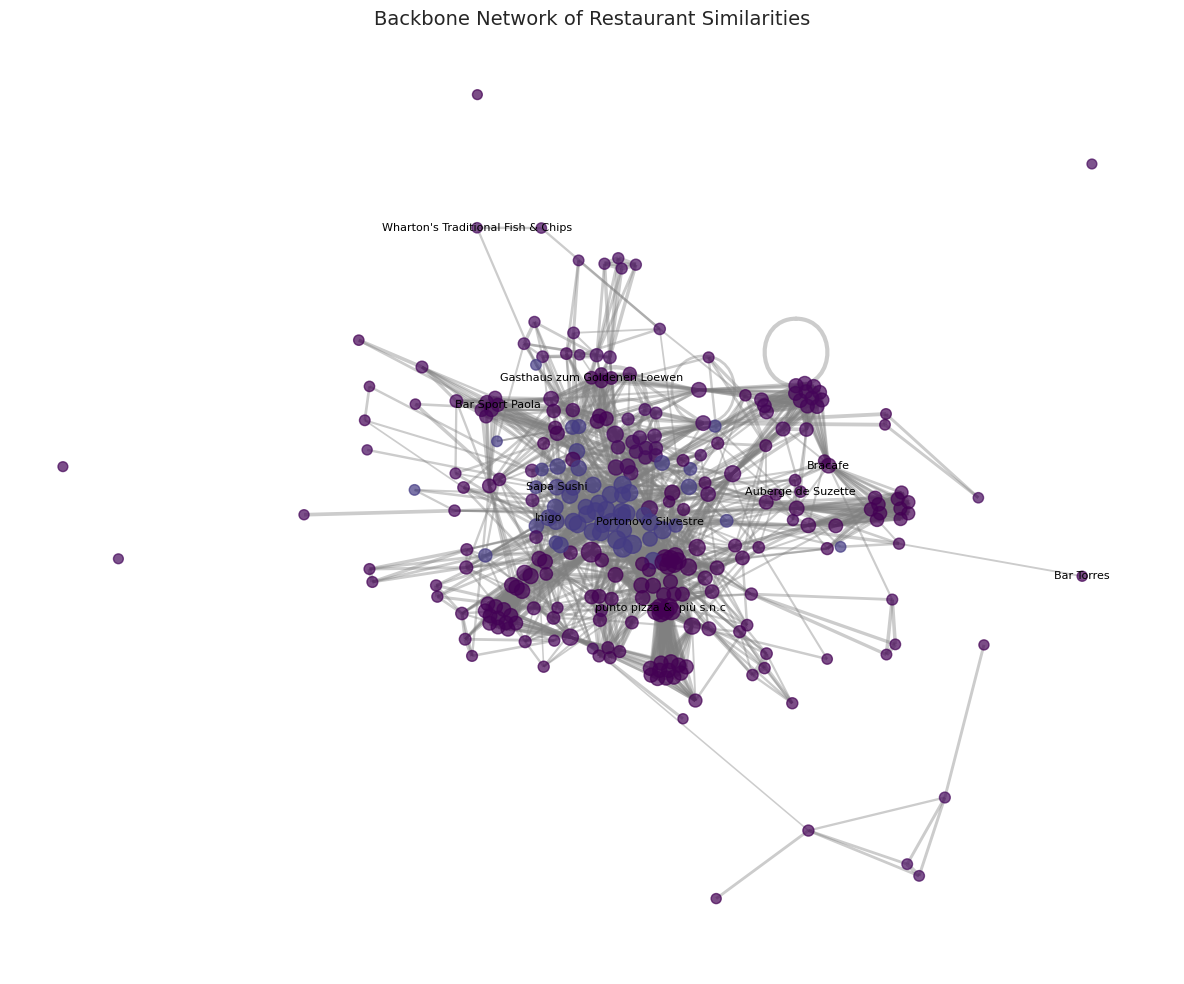

Visualization saved to ./task12_backbone_network.png


In [172]:


# Step 3: Visualize the backbone with Matplotlib
def visualize_backbone_matplotlib(graph, comm_df=None, sample_size=300):
    """Visualize a sampled backbone subgraph using Matplotlib."""
    if graph.number_of_nodes() == 0:
        print("Cannot visualize: Backbone graph is empty.")
        return
    
    # Sample nodes
    sample_nodes = list(graph.nodes())[:min(sample_size, graph.number_of_nodes())]
    G_sample = graph.subgraph(sample_nodes)
    print(f"Visualization subgraph: {G_sample.number_of_nodes()} nodes, {G_sample.number_of_edges()} edges")

    # Use spring layout for positioning
    pos = nx.spring_layout(G_sample, seed=42, k=0.15)

    # Prepare colors based on community or degree
    if comm_df is not None and 'restaurant_name' in comm_df.columns and 'community' in comm_df.columns:
        partition = dict(zip(comm_df['restaurant_name'], comm_df['community']))
        unique_comms = set(partition.values())
        color_map = plt.get_cmap('viridis')
        comm_to_color = {comm: mcolors.to_hex(color_map(i / max(len(unique_comms), 1))) for i, comm in enumerate(unique_comms)}
        node_colors = [comm_to_color.get(partition.get(node, -1), '#888888') for node in G_sample.nodes()]
    else:
        degrees = dict(G_sample.degree())
        max_degree = max(degrees.values()) if degrees else 1
        color_map = plt.get_cmap('viridis')
        comm_to_color = {deg: mcolors.to_hex(color_map(deg / max_degree)) for deg in set(degrees.values())}
        node_colors = [comm_to_color.get(degrees.get(node, 0), '#888888') for node in G_sample.nodes()]

    # Node sizes based on degree
    degrees = dict(G_sample.degree())
    max_degree = max(degrees.values()) if degrees else 1
    min_size, max_size = 50, 200
    node_sizes = [min_size + (max_size - min_size) * (degrees.get(node, 0) / max_degree) 
                  for node in G_sample.nodes()]

    # Create the plot
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(G_sample, pos, node_color=node_colors, node_size=node_sizes, alpha=0.7)
    edge_widths = [d.get('weight', 1) * 3 for u, v, d in G_sample.edges(data=True)]
    nx.draw_networkx_edges(G_sample, pos, width=edge_widths, alpha=0.4, edge_color='gray')
    
    # Label a subset of nodes
    labels = {node: node for node in sample_nodes[:10]}  # Label first 10 nodes
    nx.draw_networkx_labels(G_sample, pos, labels, font_size=8, font_color='black')

    plt.title("Backbone Network of Restaurant Similarities", fontsize=14, pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("/kaggle/working/task12_backbone_network.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("Visualization saved to ./task12_backbone_network.png")

# Call the visualization function
visualize_backbone_matplotlib(G_backbone, comm_df)



In [173]:
# Step 4: Save outputs
nx.write_gml(G_backbone, '/kaggle/working/task12_backbone_graph.gml')
analysis_df.to_csv('/kaggle/working/task12_backbone_analysis.csv', index=False)
print("Saved backbone graph to /kaggle/working/task12_backbone_graph.gml")
print("Saved analysis to /kaggle/working/task12_backbone_analysis.csv")

Saved backbone graph to /kaggle/working/task12_backbone_graph.gml
Saved analysis to /kaggle/working/task12_backbone_analysis.csv


### 13. Recommendation via Network Proximity
- For a given restaurant, suggest similar ones based on shortest paths, common neighbors, or graph embeddings.
- Evaluate how well these recommendations align with shared features or cuisines.

In [180]:

from sklearn.metrics import jaccard_score

In [174]:
# Load the backbone graph from Task 12
G_backbone = nx.read_gml('/kaggle/working/task12_backbone_graph.gml')
print(f"Loaded backbone graph: {G_backbone.number_of_nodes()} nodes, {G_backbone.number_of_edges()} edges")

# Load the original DataFrame (Task 2)
df = pd.read_parquet('/kaggle/working/task2_df.parquet')
print(f"Loaded DataFrame: {len(df)} rows")


Loaded backbone graph: 4175 nodes, 528199 edges
Loaded DataFrame: 5000 rows


In [175]:

# Ensure restaurant_name is a column and matches graph nodes
if 'restaurant_name' not in df.columns:
    raise KeyError("Column 'restaurant_name' not found in task2_df.parquet.")
df = df[df['restaurant_name'].isin(G_backbone.nodes())].reset_index(drop=True)
print(f"Filtered DataFrame to match graph: {len(df)} rows")

# Preprocess top_tags for comparison
def preprocess_tags(tags):
    if pd.isna(tags) or not tags:
        return set()
    if isinstance(tags, list):
        return set(str(tag).lower() for tag in tags if tag)
    return set(str(tags).lower().split())

df['tags_set'] = df['top_tags'].apply(preprocess_tags)
print("Preprocessed top_tags into sets for comparison")


Filtered DataFrame to match graph: 4316 rows
Preprocessed top_tags into sets for comparison


### Recommendation Functions

### recommend_by_shortest_path 

In [176]:

def recommend_by_shortest_path(graph, target_restaurant, df, k=5):
    """Recommend restaurants based on shortest path length."""
    if target_restaurant not in graph.nodes():
        print(f"Restaurant '{target_restaurant}' not in graph.")
        return []
    
    # Compute shortest path lengths to all other nodes
    try:
        lengths = nx.single_source_shortest_path_length(graph, target_restaurant)
        # Exclude the target itself and sort by path length
        recommendations = [(node, length) for node, length in lengths.items() if node != target_restaurant]
        recommendations.sort(key=lambda x: x[1])  # Sort by length
        return [node for node, _ in recommendations[:k]]  # Top k recommendations
    except nx.NetworkXNoPath:
        print(f"No paths found from '{target_restaurant}'.")
        return []

### recommend_by_common_neighbors

In [177]:
def recommend_by_common_neighbors(graph, target_restaurant, df, k=5):
    """Recommend restaurants based on number of common neighbors."""
    if target_restaurant not in graph.nodes():
        print(f"Restaurant '{target_restaurant}' not in graph.")
        return []
    
    # Get neighbors of the target
    target_neighbors = set(graph.neighbors(target_restaurant))
    if not target_neighbors:
        print(f"No neighbors found for '{target_restaurant}'.")
        return []
    
    # Compute common neighbors for all other nodes
    scores = {}
    for node in graph.nodes():
        if node != target_restaurant:
            other_neighbors = set(graph.neighbors(node))
            common = len(target_neighbors & other_neighbors)
            scores[node] = common
    
    # Sort by number of common neighbors and get top k
    recommendations = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [node for node, _ in recommendations[:k] if scores[node] > 0]  # Exclude zero common neighbors


### step 2 . Evaluation Function

In [186]:
def evaluate_recommendations(target_restaurant, recommendations, df):
    """Evaluate recommendations by Jaccard similarity of top_tags."""
    if target_restaurant not in df['restaurant_name'].values:
        print(f"Target '{target_restaurant}' not in DataFrame.")
        return []
    
    target_tags = df.loc[df['restaurant_name'] == target_restaurant, 'tags_set'].iloc[0]
    if not target_tags:
        print(f"No tags available for '{target_restaurant}'.")
        return []
    
    similarities = []
    for rec in recommendations:
        if rec in df['restaurant_name'].values:
            rec_tags = df.loc[df['restaurant_name'] == rec, 'tags_set'].iloc[0]
            if rec_tags:
                # Create a shared vocabulary (union of tags)
                all_tags = list(target_tags | rec_tags)
                if not all_tags:  # Skip if no tags overlap
                    continue
                # Create binary vectors over the shared vocabulary
                target_vec = [1 if tag in target_tags else 0 for tag in all_tags]
                rec_vec = [1 if tag in rec_tags else 0 for tag in all_tags]
                # Compute Jaccard similarity
                similarity = jaccard_score(target_vec, rec_vec, average='binary')
                similarities.append((rec, similarity))
    
    return similarities

### # Step 3: Usage

In [188]:


target_restaurant = "McDonald's"  # Example target; replace with a valid restaurant name from your graph
k = 5  # Number of recommendations

# Get recommendations
recs_shortest = recommend_by_shortest_path(G_backbone, target_restaurant, df, k)
recs_common = recommend_by_common_neighbors(G_backbone, target_restaurant, df, k)

print(f"\nRecommendations for '{target_restaurant}':")
print(f"Shortest Path (top {k}): {recs_shortest}")
print(f"Common Neighbors (top {k}): {recs_common}")

# Evaluate recommendations
eval_shortest = evaluate_recommendations(target_restaurant, recs_shortest, df)
eval_common = evaluate_recommendations(target_restaurant, recs_common, df)

print("\nEvaluation (Jaccard Similarity with Target Tags):")
if eval_shortest:
    print("Shortest Path:")
    for rec, sim in eval_shortest:
        print(f"  {rec}: {sim:.4f}")
if eval_common:
    print("Common Neighbors:")
    for rec, sim in eval_common:
        print(f"  {rec}: {sim:.4f}")



Recommendations for 'McDonald's':
Shortest Path (top 5): ['Gasthaus zum Goldenen Loewen', "Nick's Chippy", 'Curry & Chilli', 'Strandhalle Harriersand', 'Stortebeker']
Common Neighbors (top 5): ['Burger King', 'KFC', 'BFR Gianicolense', 'Nordsee', 'Mezzo di pasta']

Evaluation (Jaccard Similarity with Target Tags):
Shortest Path:
  Gasthaus zum Goldenen Loewen: 0.2500
  Nick's Chippy: 0.2500
  Curry & Chilli: 0.3333
  Strandhalle Harriersand: 0.0000
  Stortebeker: 0.0000
Common Neighbors:
  Burger King: 0.0000
  KFC: 0.0000
  BFR Gianicolense: 0.2500
  Nordsee: 0.3333
  Mezzo di pasta: 0.2500


In [190]:
# Step 4: Save results
results = {
    'target_restaurant': [target_restaurant] * (2 * k),
    'method': ['shortest_path'] * k + ['common_neighbors'] * k,
    'recommended_restaurant': recs_shortest + recs_common,
    'jaccard_similarity': [sim for _, sim in eval_shortest + eval_common] if eval_shortest and eval_common else [0] * (2 * k)
}
results_df = pd.DataFrame(results)
print(results_df)
# results_df.to_csv('/kaggle/working/task13_recommendations.csv', index=False)
# print("Saved recommendations to /kaggle/working/task13_recommendations.csv")

  target_restaurant            method        recommended_restaurant  \
0        McDonald's     shortest_path  Gasthaus zum Goldenen Loewen   
1        McDonald's     shortest_path                 Nick's Chippy   
2        McDonald's     shortest_path                Curry & Chilli   
3        McDonald's     shortest_path       Strandhalle Harriersand   
4        McDonald's     shortest_path                   Stortebeker   
5        McDonald's  common_neighbors                   Burger King   
6        McDonald's  common_neighbors                           KFC   
7        McDonald's  common_neighbors              BFR Gianicolense   
8        McDonald's  common_neighbors                       Nordsee   
9        McDonald's  common_neighbors                Mezzo di pasta   

   jaccard_similarity  
0            0.250000  
1            0.250000  
2            0.333333  
3            0.000000  
4            0.000000  
5            0.000000  
6            0.000000  
7            0.250000  
8 